In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import cv2
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset

# 1. Data Preperation

## 1.0. Important functions

In [2]:
def display_all_cols(df):
    with pd.option_context('display.max_columns', None):
        print(df.head())


In [3]:
# load ids into list 
def load_file_to_list(file_path):
    """
    loads a text file to a list with each entry on a new line becoming a new entry in the list.

    :param file_path: Path to the file where the list should be saved.
    :return list of data from file
    """
    # Open the file for writing
    lst = []
    with open(file_path, 'r') as file:
        # Write each item on a new line
        for line in file:
            lst.append(line.strip())
    return lst

In [4]:
def df_to_json(df, path):
    """
    Converts a DataFrame to a .json file.

    Parameters:
    df (pd.DataFrame): The DataFrame to be converted to JSON.
    path (str): The path (including file name) where the .json file will be saved.
    """
    df.to_json(path, orient='records', indent=4)

In [5]:

def json_to_df(path):
    """
    Converts a .json file to a DataFrame.

    Parameters:
    path (str): The path to the .json file that will be read.

    Returns:
    pd.DataFrame: The DataFrame created from the JSON file.
    """
    print(path)
    df = pd.read_json(path, orient='records')
    print(f"JSON file has been successfully converted to DataFrame.")
    return df

In [6]:
def set_dtypes_df_full_annotation_abs(df):
    df['vid_id'] = df['vid_id'].astype(str)
    df['img_id'] = df['img_id'].astype(str)
    df['bbox_id'] = df['bbox_id'].astype(str)
    df['bbox_c_x'] = df['bbox_c_x'].astype('float32')
    df['bbox_c_y'] = df['bbox_c_y'].astype('float32')
    df['bbox_w'] = df['bbox_w'].astype('float32')
    df['bbox_h'] = df['bbox_h'].astype('float32')
    df['Head_x'] = df['Head_x'].astype('float32')
    df['Head_y'] = df['Head_y'].astype('float32')
    df['Beak_x'] = df['Beak_x'].astype('float32')
    df['Beak_y'] = df['Beak_y'].astype('float32')
    df['Body_top_x'] = df['Body_top_x'].astype('float32')
    df['Body_top_y'] = df['Body_top_y'].astype('float32')
    df['RFlipper_mid_x'] = df['RFlipper_mid_x'].astype('float32')
    df['RFlipper_mid_y'] = df['RFlipper_mid_y'].astype('float32')
    df['LFlipper_mid_x'] = df['LFlipper_mid_x'].astype('float32')
    df['LFlipper_mid_y'] = df['LFlipper_mid_y'].astype('float32')
    df['Body_bottom_x'] = df['Body_bottom_x'].astype('float32')
    df['Body_bottom_y'] = df['Body_bottom_y'].astype('float32')
    df['RFoot_x'] = df['RFoot_x'].astype('float32')
    df['RFoot_y'] = df['RFoot_y'].astype('float32')
    df['LFoot_x'] = df['LFoot_x'].astype('float32')
    df['LFoot_y'] = df['LFoot_y'].astype('float32')
    df['kp_outside_best_bbox'] = df['kp_outside_best_bbox'].astype('float32')
    df['kp_missing'] = df['kp_missing'].astype('float32')
    df['kp_primary_missing'] = df['kp_primary_missing'].astype(bool)
    df['img_width'] = df['img_width'].astype('float32')
    df['img_height'] = df['img_height'].astype('float32')
    df['bbox_max_h_w'] = df['bbox_max_h_w'].astype('float32')
    return df

## 1.1. Extract and save only the desired keypoints

In [2]:
# get a list of all the video names
def get_unique_video_names(directory):
    """
    Scans the given directory for video files and returns a list of unique file names without the extension.
    
    Parameters:
    directory (str): The path to the directory containing the video files.

    Returns:
    list: A list of unique video file names without extensions.
    """
    unique_names = set()
    
    # Supported video file extensions
    video_extensions = {'.mp4', '.mjpeg'}
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        # Split the filename and extension
        name, ext = os.path.splitext(filename)
        # Check if the file has a video extension
        if ext.lower() in video_extensions:
            unique_names.add(name)  # Add the name to the set (ensures uniqueness)
    
    # Convert the set to a list and return
    return list(unique_names)

In [4]:
#Simple
list_of_vids = get_unique_video_names('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_videos')
print(len(list_of_vids))
print(list_of_vids[0])

50
stand2


In [5]:
# copy and rename csv files that contain annotations
def copy_csv_files(ids, source_dir, destination_dir):
    """
    Copies CSV files from sub-directories that match the given IDs and renames them to the ID.
    
    Parameters:
    ids (list): A list of IDs (sub-directory names) to search for.
    source_dir (str): The path to the root directory containing sub-directories.
    destination_dir (str): The path to the directory where the CSV files should be copied and renamed.
    """
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    for id_ in ids:
        subdir_path = os.path.join(source_dir, id_)
        
        if os.path.isdir(subdir_path):
            # Find the CSV file in the sub-directory
            for file_name in os.listdir(subdir_path):
                if file_name.endswith('.csv'):
                    csv_file_path = os.path.join(subdir_path, file_name)
                    
                    # Create the destination file path
                    destination_file_path = os.path.join(destination_dir, f"{id_}.csv")
                    
                    # Copy the CSV file to the destination directory with the new name
                    shutil.copy(csv_file_path, destination_file_path)
                    print(f"Copied {csv_file_path} to {destination_file_path}")
                    break  # Assuming there is only one CSV file per sub-directory
        else:
            print(f"Sub-directory '{id_}' not found in '{source_dir}'.")

In [8]:
source_directory = '/home/matthew/Desktop/Masters/Masters-data/Roanne Penguins 2022/Penguin Project Annotation and Videos/Penguin Annotations/P1_labeled-data'
destination_directory = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/DLC_Annotations'

copy_csv_files(list_of_vids, source_directory, destination_directory)

Copied /home/matthew/Desktop/Masters/Masters-data/Roanne Penguins 2022/Penguin Project Annotation and Videos/Penguin Annotations/P1_labeled-data/stand2/CollectedData_Ro.csv to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/DLC_Annotations/stand2.csv
Copied /home/matthew/Desktop/Masters/Masters-data/Roanne Penguins 2022/Penguin Project Annotation and Videos/Penguin Annotations/P1_labeled-data/walk57/CollectedData_Ro.csv to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/DLC_Annotations/walk57.csv
Copied /home/matthew/Desktop/Masters/Masters-data/Roanne Penguins 2022/Penguin Project Annotation and Videos/Penguin Annotations/P1_labeled-data/stand4/CollectedData_Ro.csv to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/DLC_Annotations/stand4.csv
Copied /home/matthew/Desktop/Masters/Masters-data/Roanne Penguins 2022/Penguin Project Annotation and Videos/Penguin Annotations/P1_labeled

### load csv to a dataframe and remove the keypoints not required
need it to look like:
vid_id,img_id,Head,Head,Beak,Beak,Body_top,Body_top,RFlipper_mid,RFlipper_mid,LFlipper_mid,LFlipper_mid,Body_bottom,Body_bottom,RFoot,RFoot,LFoot,LFoot

In [11]:
# read csv into a df
df = pd.read_csv('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/DLC_Annotations/flap1.csv')

In [14]:
# test df function
# print(df.head())
# print(df.info())
# print(df.describe())

         scorer Unnamed: 1  Unnamed: 2                  Ro               Ro.1  \
0   individuals        NaN         NaN                 ID1                ID1   
1     bodyparts        NaN         NaN                Head               Head   
2        coords        NaN         NaN                   x                  y   
3  labeled-data      flap1  img010.png  1232.9652201659226  84.75820038289726   
4  labeled-data      flap1  img014.png  1232.9652201659226  78.32552648372689   

                 Ro.2                Ro.3                Ro.4  \
0                 ID1                 ID1                 ID1   
1                Beak                Beak            Body_top   
2                   x                   y                   x   
3  1326.2389917038931   144.2604339502234  1184.7201659221446   
4   1331.063497128271  134.61142310146784  1189.5446713465224   

                 Ro.5                Ro.6  ...               Ro.18  \
0                 ID1                 ID1  ...      

In [38]:
# step through list of videos/csv ids and create a list of dfs
list_of_kp_df_raw = []

# step through the list of ids and load each csv into a df and add to list
for _id in list_of_vids:
    
    # load csv to a temp df
    print(_id)
    df = pd.read_csv(f'/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/DLC_Annotations/{_id}.csv')
    list_of_kp_df_raw.append(df)

stand2
walk57
stand4
flap4
preen40
walk68
preen46
preen30
rest8
walk6
flap13
stand67
stand11
stand19
walk80
rest42
rest30
stand6
stand75
flap12
flap14
walk62
walk64
preen48
stand79
flap3
rest65
stand72
rest44
rest47
preen33
flap7
stand9
preen35
rest24
walk82
rest19
preen50
stand82
flap2
walk66
rest39
preen31
preen37
rest15
flap1
walk89
preen84
walk86
stand69


In [39]:
# print(list_of_kp_df_raw)

[          scorer Unnamed: 1  Unnamed: 2                 Ro  \
0    individuals        NaN         NaN                ID1   
1      bodyparts        NaN         NaN               Head   
2         coords        NaN         NaN                  x   
3   labeled-data     stand2  img000.png  719.9594767070839   
4   labeled-data     stand2  img023.png  723.1758136566691   
5   labeled-data     stand2  img048.png  750.5146777281432   
6   labeled-data     stand2  img056.png   747.298340778558   
7   labeled-data     stand2  img079.png  782.6780472239952   
8   labeled-data     stand2  img099.png  771.4208679004469   
9   labeled-data     stand2  img112.png   739.257498404595   
10  labeled-data     stand2  img119.png  723.1758136566691   
11  labeled-data     stand2  img123.png  723.1758136566691   
12  labeled-data     stand2  img145.png  618.6448627951502   

                  Ro.1               Ro.2                Ro.3  \
0                  ID1                ID1                 ID1   


In [51]:
# append master df from csv to df with correct kp and column names
######  THIS WILL HAVE TO BE UPDATED WHEN HAVE LOTS OF PENGUINS. JUST ADD AN IF STATEMENT TO PUT ADDITIONAL COLUMNS
######  AS A ADDITIONAL ENTRY AND ADD A BOUNDING BBOX NUMBER COLUMN. THIS WILL LEAD TO SOME EMPTY ROWS IF A PENGUIN
######  ENTRERS THE FRAME. SO FINALLY REMOVE ANY EMPTY ROWS
def consolidate_dataframes(source_dfs):
    """
    Consolidates data from multiple source DataFrames into a single DataFrame with specific columns.
    
    Parameters:
    source_dfs (list of pd.DataFrame): List of source DataFrames to be consolidated.

    Returns:
    pd.DataFrame: A consolidated DataFrame with the selected columns.
    """
    consolidated_df = pd.DataFrame(columns=[
        'vid_id', 'image_id', 'Head_x', 'Head_y', 'Beak_x', 'Beak_y',
        'Body_top_x', 'Body_top_y', 'RFlipper_mid_x', 'RFlipper_mid_y',
        'LFlipper_mid_x', 'LFlipper_mid_y', 'Body_bottom_x', 'Body_bottom_y',
        'RFoot_x', 'RFoot_y', 'LFoot_x', 'LFoot_y'
    ])

    for df in source_dfs:
        # Skip the first 4 rows (headers)
        df = df.iloc[3:]
        
        # Create a temporary DataFrame to hold the required columns
        temp_df = pd.DataFrame({
            'vid_id': df.iloc[:, 1],  # Column 2 (index 1)
            'image_id': range(len(df)),  # Sequential image_id starting from 0
            'Head_x': df.iloc[:, 3],  # Column 4 (index 3)
            'Head_y': df.iloc[:, 4],  # Column 5 (index 4)
            'Beak_x': df.iloc[:, 5],  # Column 6 (index 5)
            'Beak_y': df.iloc[:, 6],  # Column 7 (index 6)
            'Body_top_x': df.iloc[:, 7],  # Column 8 (index 7)
            'Body_top_y': df.iloc[:, 8],  # Column 9 (index 8)
            'RFlipper_mid_x': df.iloc[:, 13],  # Column 14 (index 13)
            'RFlipper_mid_y': df.iloc[:, 14],  # Column 15 (index 14)
            'LFlipper_mid_x': df.iloc[:, 15],  # Column 16 (index 15)
            'LFlipper_mid_y': df.iloc[:, 16],  # Column 17 (index 16)
            'Body_bottom_x': df.iloc[:, 23],  # Column 24 (index 23)
            'Body_bottom_y': df.iloc[:, 24],  # Column 25 (index 24)
            'RFoot_x': df.iloc[:, 27],  # Column 28 (index 27)
            'RFoot_y': df.iloc[:, 28],  # Column 29 (index 28)
            'LFoot_x': df.iloc[:, 29],  # Column 30 (index 29)
            'LFoot_y': df.iloc[:, 30]  # Column 31 (index 30)
        })

        # Append the temp_df to the consolidated DataFrame
        consolidated_df = pd.concat([consolidated_df, temp_df], ignore_index=True)

    return consolidated_df


In [52]:
master_kp_df = consolidate_dataframes(list_of_kp_df_raw)

In [70]:
master_kp_df.head(30)

,vid_id,image_id,Head_x,Head_y,Beak_x,Beak_y,Body_top_x,Body_top_y,RFlipper_mid_x,RFlipper_mid_y,LFlipper_mid_x,LFlipper_mid_y,Body_bottom_x,Body_bottom_y,RFoot_x,RFoot_y,LFoot_x,LFoot_y
0,stand2,0,719.9594767070839,91.19087428206763,535.020102105935,124.96241225271228,938.6703892788771,248.79138481174232,782.6780472239952,557.559731971921,1073.7565411614553,649.2253350350991,1184.7201659221446,649.2253350350991,892.0335035098917,835.7728781110404,996.5644543714106,893.666943203574
1,stand2,1,723.1758136566691,94.40721123165304,559.142629227824,165.1666241225273,896.8580089342695,258.44039566049787,731.2166560306321,568.8169112954691,1035.160497766433,642.7926611359287,1138.0832801531592,657.266177409062,850.2211231652843,851.8545628589663,959.5765794511808,916.1813018506703
2,stand2,2,750.5146777281432,118.52973835354192,687.7961072112319,208.5871729419273,882.3844926611362,264.87306955966824,710.3104658583281,576.8577536694322,1014.2543075941292,652.4416719846843,1118.785258455648,668.5233567326102,837.3557753669434,871.1525845564774,937.0622208040845,930.6548181238036
3,stand2,3,747.298340778558,134.61142310146784,691.012444160817,227.88519463943862,888.8171665603065,276.1302488832165,719.9594767070839,588.1149329929804,1020.6869814932995,662.0906828334398,1115.568921506063,660.4825143586472,842.1802807913211,872.76075303127,938.6703892788771,940.3038289725591
4,stand2,4,782.6780472239952,141.0440970006382,728.0003190810469,242.35871091257195,909.7233567326105,266.48123803446083,745.6901723037654,581.68225909381,1048.0258455647738,657.266177409062,1149.3404594767073,673.3478621569881,872.7354818123806,875.9770899808553,969.2255902999364,933.8711550733888
5,stand2,5,771.4208679004469,150.69310784939375,689.4042756860244,240.75054243777936,919.372367581366,272.9139119336312,737.6493299298024,589.723101467773,1054.4585194639442,671.7396936821955,1158.989470325463,676.5641991065733,866.3028079132102,874.3689215060626,964.4010848755586,938.6956604977665
6,stand2,6,739.257498404595,187.6809827696236,652.4164007657947,322.7671346522018,904.8988513082325,280.95475430759427,728.0003190810469,589.723101467773,1049.6340140395664,674.9560306317807,1144.5159540523296,674.9560306317807,861.4783024888325,879.1934269304405,954.752074026803,940.3038289725591
7,stand2,7,723.1758136566691,229.49336311423122,647.591895341417,367.79585194639446,911.331525207403,284.17109125717946,739.257498404595,588.1149329929804,1064.1075303126997,674.9560306317807,1160.5976388002555,674.9560306317807,882.3844926611362,887.2342693044035,974.0500957243144,941.9119974473517
8,stand2,8,723.1758136566691,248.79138481174232,637.9428844926613,383.8775366943205,916.1560306317808,292.2119336311424,753.7310146777284,599.3721123165285,1068.9320357370775,699.0785577536695,1168.6384811742187,670.1315252074029,880.7763241863436,879.1934269304405,980.4827696234847,938.6956604977665
9,stand2,9,618.6448627951502,353.32233567326114,514.1139119336314,493.2329929802171,863.0864709636251,303.46911295469056,753.7310146777284,612.2374601148694,1065.7156987874923,694.2540523292918,1160.5976388002555,641.1844926611361,869.5191448627954,885.6261008296109,975.658264199107,935.4793235481814


In [71]:
master_kp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   vid_id          500 non-null    object
 1   image_id        500 non-null    object
 2   Head_x          496 non-null    object
 3   Head_y          496 non-null    object
 4   Beak_x          463 non-null    object
 5   Beak_y          463 non-null    object
 6   Body_top_x      489 non-null    object
 7   Body_top_y      489 non-null    object
 8   RFlipper_mid_x  366 non-null    object
 9   RFlipper_mid_y  366 non-null    object
 10  LFlipper_mid_x  414 non-null    object
 11  LFlipper_mid_y  414 non-null    object
 12  Body_bottom_x   490 non-null    object
 13  Body_bottom_y   490 non-null    object
 14  RFoot_x         402 non-null    object
 15  RFoot_y         402 non-null    object
 16  LFoot_x         380 non-null    object
 17  LFoot_y         380 non-null    object
dtypes: object(

In [79]:
# save to json
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/reduced_kp_raw_Simple.json'
df_to_json(master_kp_df, path)

## 1.2. Save df as a json (and vice versa) and set the datatypes

In [2]:
def df_to_json(df, path):
    """
    Converts a DataFrame to a .json file.

    Parameters:
    df (pd.DataFrame): The DataFrame to be converted to JSON.
    path (str): The path (including file name) where the .json file will be saved.
    """
    df.to_json(path, orient='records', indent=4)

In [3]:

def json_to_df(path):
    """
    Converts a .json file to a DataFrame.

    Parameters:
    path (str): The path to the .json file that will be read.

    Returns:
    pd.DataFrame: The DataFrame created from the JSON file.
    """
    print(path)
    df = pd.read_json(path, orient='records')
    print(f"JSON file has been successfully converted to DataFrame.")
    return df

In [4]:
def set_dtypes_df_full_annotation_abs(df):
    df['vid_id'] = df['vid_id'].astype(str)
    df['img_id'] = df['img_id'].astype(str)
    df['bbox_id'] = df['bbox_id'].astype(str)
    df['bbox_c_x'] = df['bbox_c_x'].astype('float32')
    df['bbox_c_y'] = df['bbox_c_y'].astype('float32')
    df['bbox_w'] = df['bbox_w'].astype('float32')
    df['bbox_h'] = df['bbox_h'].astype('float32')
    df['Head_x'] = df['Head_x'].astype('float32')
    df['Head_y'] = df['Head_y'].astype('float32')
    df['Beak_x'] = df['Beak_x'].astype('float32')
    df['Beak_y'] = df['Beak_y'].astype('float32')
    df['Body_top_x'] = df['Body_top_x'].astype('float32')
    df['Body_top_y'] = df['Body_top_y'].astype('float32')
    df['RFlipper_mid_x'] = df['RFlipper_mid_x'].astype('float32')
    df['RFlipper_mid_y'] = df['RFlipper_mid_y'].astype('float32')
    df['LFlipper_mid_x'] = df['LFlipper_mid_x'].astype('float32')
    df['LFlipper_mid_y'] = df['LFlipper_mid_y'].astype('float32')
    df['Body_bottom_x'] = df['Body_bottom_x'].astype('float32')
    df['Body_bottom_y'] = df['Body_bottom_y'].astype('float32')
    df['RFoot_x'] = df['RFoot_x'].astype('float32')
    df['RFoot_y'] = df['RFoot_y'].astype('float32')
    df['LFoot_x'] = df['LFoot_x'].astype('float32')
    df['LFoot_y'] = df['LFoot_y'].astype('float32')
    df['kp_outside_best_bbox'] = df['kp_outside_best_bbox'].astype('float32')
    df['kp_missing'] = df['kp_missing'].astype('float32')
    df['kp_primary_missing'] = df['kp_primary_missing'].astype(bool)
    df['img_width'] = df['img_width'].astype('float32')
    df['img_height'] = df['img_height'].astype('float32')
    return df

## 1.3. Create a single annotation with bbox and keypoints in the correct form and linked

### Load keypoints df and make them the correct format

In [26]:
# load the reduced_kp_raw_Simple_df
df_reduced_kp_raw = json_to_df('/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/reduced_kp_raw_Simple.json')

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/reduced_kp_raw_Simple.json
JSON file has been successfully converted to DataFrame.


In [27]:
df_reduced_kp_raw.head()


,vid_id,image_id,Head_x,Head_y,Beak_x,Beak_y,Body_top_x,Body_top_y,RFlipper_mid_x,RFlipper_mid_y,LFlipper_mid_x,LFlipper_mid_y,Body_bottom_x,Body_bottom_y,RFoot_x,RFoot_y,LFoot_x,LFoot_y
0,stand2,0,719.959477,91.190874,535.020102,124.962412,938.670389,248.791385,782.678047,557.559732,1073.756541,649.225335,1184.720166,649.225335,892.033504,835.772878,996.564454,893.666943
1,stand2,1,723.175814,94.407211,559.142629,165.166624,896.858009,258.440396,731.216656,568.816911,1035.160498,642.792661,1138.083280,657.266177,850.221123,851.854563,959.576579,916.181302
2,stand2,2,750.514678,118.529738,687.796107,208.587173,882.384493,264.873070,710.310466,576.857754,1014.254308,652.441672,1118.785258,668.523357,837.355775,871.152585,937.062221,930.654818
3,stand2,3,747.298341,134.611423,691.012444,227.885195,888.817167,276.130249,719.959477,588.114933,1020.686981,662.090683,1115.568922,660.482514,842.180281,872.760753,938.670389,940.303829
4,stand2,4,782.678047,141.044097,728.000319,242.358711,909.723357,266.481238,745.690172,581.682259,1048.025846,657.266177,1149.340459,673.347862,872.735482,875.977090,969.225590,933.871155


In [28]:
# correct the format of the keypoints
    # 1st string
df_reduced_kp_raw.iloc[:, 0] = df_reduced_kp_raw.iloc[:, 0].astype(str)

# Ensure the second column is an integer
df_reduced_kp_raw.iloc[:, 1] = df_reduced_kp_raw.iloc[:, 1].astype(str)

# Format the remaining columns as floats with minimal decimal points
for col in df_reduced_kp_raw.columns[2:]:
    df_reduced_kp_raw[col] = df_reduced_kp_raw[col].astype(np.float32)

In [29]:
df_reduced_kp_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   vid_id          500 non-null    object 
 1   image_id        500 non-null    object 
 2   Head_x          496 non-null    float32
 3   Head_y          496 non-null    float32
 4   Beak_x          463 non-null    float32
 5   Beak_y          463 non-null    float32
 6   Body_top_x      489 non-null    float32
 7   Body_top_y      489 non-null    float32
 8   RFlipper_mid_x  366 non-null    float32
 9   RFlipper_mid_y  366 non-null    float32
 10  LFlipper_mid_x  414 non-null    float32
 11  LFlipper_mid_y  414 non-null    float32
 12  Body_bottom_x   490 non-null    float32
 13  Body_bottom_y   490 non-null    float32
 14  RFoot_x         402 non-null    float32
 15  RFoot_y         402 non-null    float32
 16  LFoot_x         380 non-null    float32
 17  LFoot_y         380 non-null    flo

### Load bboxes into a df to be used and correct format

In [15]:
# step through bounding box text files and create a df with the following output
# vid_id,img_id,bbox_c_x, bbox_c_y, bbox_w, bbox_h
def bbox_txt_files_to_df(directory):
    """
    Processes all text files in the given directory and returns a DataFrame with the columns:
    vid_id, img_id, bbox_c_x, bbox_c_y, bbox_w, bbox_h.

    Parameters:
    directory (str): Path to the directory containing the text files.

    Returns:
    pd.DataFrame: The processed DataFrame.
    """
    data = []
    #count = 0

    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            # Extract vid_id and img_id from the filename
            parts = filename.split('_')
            vid_id = parts[1].split('.')[0]
            img_id = parts[-1].split('.')[0]
            #print(img_id)

            # Read the text file
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                for line in file:
                    figures = line.strip().split()
                    if len(figures) == 5:
                        bbox_c_x, bbox_c_y, bbox_w, bbox_h = map(float, figures[1:])
                        data.append([vid_id, img_id, np.float32(bbox_c_x), np.float32(bbox_c_y), np.float32(bbox_w), np.float32(bbox_h)])
                        #count += 1
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=['vid_id', 'img_id', 'bbox_c_x', 'bbox_c_y', 'bbox_w', 'bbox_h'])

    return df

In [16]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_annotations'

bbox_df_raw = bbox_txt_files_to_df(path)

In [17]:
bbox_df_raw.head()

,vid_id,img_id,bbox_c_x,bbox_c_y,bbox_w,bbox_h
0,rest8,7,0.591797,0.439697,0.551758,0.724121
1,rest24,7,0.571777,0.490234,0.478760,0.332520
2,stand6,8,0.543457,0.551758,0.209351,0.668457
3,rest39,5,0.535645,0.484131,0.372070,0.539062
4,preen84,1,0.539551,0.584473,0.234375,0.523438


In [18]:
bbox_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   vid_id    500 non-null    object 
 1   img_id    500 non-null    object 
 2   bbox_c_x  500 non-null    float32
 3   bbox_c_y  500 non-null    float32
 4   bbox_w    500 non-null    float32
 5   bbox_h    500 non-null    float32
dtypes: float32(4), object(2)
memory usage: 15.8+ KB


In [19]:
# see where there are more than one bounding box per image
duplicates = bbox_df_raw[bbox_df_raw.duplicated(['vid_id', 'img_id'], keep=False)]

In [22]:
duplicates.head(30)

,vid_id,img_id,bbox_c_x,bbox_c_y,bbox_w,bbox_h


### Get image size stored

In [30]:
# step through image files and create a df with the following output
# vid_id,img_id,img_wid,img_height

def image_files_to_df(directory):
    """
    Processes all .jpg image files in the given directory and returns a DataFrame with the columns:
    vid_id, img_id, img_wid, img_height.

    Parameters:
    directory (str): Path to the directory containing the image files.

    Returns:
    pd.DataFrame: The processed DataFrame.
    """
    data = []

    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            # Extract vid_id and img_id from the filename
            parts = filename.split('_')
            vid_id = parts[1].split('.')[0]
            img_id = parts[-1].split('.')[0]

            # Read the image file and get its dimensions
            filepath = os.path.join(directory, filename)
            with Image.open(filepath) as img:
                img_wid, img_height = img.size

            # Append the data to the list
            data.append([vid_id, img_id, np.float32(img_wid), np.float32(img_height)])
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=['vid_id', 'img_id', 'img_wid', 'img_height'])

    return df

In [31]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_images'

imgsize_df_raw = image_files_to_df(path)

In [32]:
imgsize_df_raw.head()

,vid_id,img_id,img_wid,img_height
0,rest65,6,1920.0,1080.0
1,walk6,9,1920.0,1080.0
2,preen35,8,1920.0,1080.0
3,walk86,9,1920.0,1080.0
4,preen46,7,1920.0,1080.0


In [33]:
imgsize_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   vid_id      500 non-null    object 
 1   img_id      500 non-null    object 
 2   img_wid     500 non-null    float32
 3   img_height  500 non-null    float32
dtypes: float32(2), object(2)
memory usage: 11.8+ KB


### Match keypoint to bbox, check for keypoints outside of bbox, match bbox ids

In [21]:
# loop through all keypoint entries in df
# for each keypoint filter the bbox df to have only those ids
# do the same for the image df
# find the bbox that will contain the most keypoints from the bbox df
#   this will require the rescaling of the bbox
#   find how many keypoints are outside the bbox
#   find how many keypoints are missing
#   find whether the primary kp are missing (True/False)
# check if this is img_id = 0 
#   yes: increment bbox_id starting at 0
#   no: find bbox from previous vid_id, img_id - 1 in final df that has the best fit and make bbox id = to that bbox_id, unless distance is over 20% of img size, then make bbox_id last bbox_id + 1
# remove the bounding box from the original bbox df - I REMOVED THIS STEP AS UNNECESSARY

In [20]:
# for each keypoint filter the bbox df to have only those ids

def filter_dataframe_based_on_another(vid_id, img_id, df_to_filter):
    """
    filters df_to_filter to show entries with the same vid_id and img_id.

    Parameters:
    vid_id: string with vid_id
    image_id: string with img_id
    df_to_filter (pd.DataFrame): The DataFrame to filter based on vid_id and img_id.

    Returns:
    list of pd.DataFrame: A list of filtered DataFrames, one for each row in df_main.
    """
        
    # Filter df_to_filter based on the current row's vid_id and img_id
    filtered_df = df_to_filter[(df_to_filter['vid_id'] == vid_id) & (df_to_filter['img_id'] == img_id)]

    return filtered_df

In [21]:
# rescale the bounding box
def denorm_bbox_df(df_bbox, img_width, img_height):
    """
    Denormalizes bounding boxes in a DataFrame from normalized values to absolute pixel values.

    Parameters:
    df_bboxes (pd.DataFrame): The DataFrame containing bounding box coordinates.
                              Expected columns: ['vid_id', 'image_id', 'bbox_c_x', 'bbox_c_y', 'bbox_w', 'bbox_h']
    img_width (int): The width of the image.
    img_height (int): The height of the image.

    Returns:
    pd.DataFrame: A DataFrame with denormalized bounding boxes.
                  Columns: ['vid_id', 'image_id', 'bbox_c_x', 'bbox_c_y', 'bbox_w', 'bbox_h']
    """
    # Create a copy of the DataFrame to avoid modifying the original DataFrame
    denorm_df = df_bbox.copy()
    #print(denorm_df)
    #print(img_width)

    # Denormalize the bounding box coordinates
    #print(denorm_df['bbox_c_x'])# * img_width)
    denorm_df['bbox_c_x'] = denorm_df['bbox_c_x'] * img_width
    denorm_df['bbox_c_y'] = denorm_df['bbox_c_y'] * img_height
    denorm_df['bbox_w'] = denorm_df['bbox_w'] * img_width
    denorm_df['bbox_h'] = denorm_df['bbox_h'] * img_height

    return denorm_df

In [22]:
# find the bbox that will contain the most keypoints from the bbox df
#   find how many keypoints are outside the bbox
#   find how many keypoints are missing
#   find whether the primary kp are missing (True/False)

def find_best_bbox(bbox_df, keypoints_df):
    """
    Finds the bounding box that contains the most keypoints and returns it along with the number
    of keypoints that fall outside that bounding box.

    Parameters:
    bbox_df (pd.DataFrame): DataFrame with bounding boxes in absolute coordinates. 
                            
    keypoints_df (pd.DataFrame): DataFrame with keypoints.
                                

    Returns:
    dict: Dictionary containing the best bounding box and the number of keypoints outside it.
    """
    best_bbox = None
    max_keypoints_inside = -1
    min_distance_to_origin = float('inf')
    keypoints_outside_best_bbox = 0
    nan_keypoint_pairs = 0
    missing_primary_keypoint = False

    # Extract keypoints and check for NaN pairs and missing primary keypoints
    keypoints = []
    for i in range(0, 16, 2):  # Since there are 8 keypoints (16 columns), we step by 2
        #print(i)
        x = keypoints_df.iloc[i+2]  
        y = keypoints_df.iloc[i+3]
        keypoints.append((x, y))

        # Check if either x or y is NaN
        if pd.isna(x) or pd.isna(y):
            nan_keypoint_pairs += 1
            if i == 4 or i == 10:
                missing_primary_keypoint = True

        #break
    count =0
    for _, bbox in bbox_df.iterrows():
        #vid_id, img_id = bbox['vid_id'], bbox['img_id']
        count=+1
        #print(count)
        bbox_c_x, bbox_c_y, bbox_w, bbox_h = bbox['bbox_c_x'], bbox['bbox_c_y'], bbox['bbox_w'], bbox['bbox_h']
        
        # Calculate the bounding box corners (x_min, y_min, x_max, y_max)
        x_min = bbox_c_x - bbox_w / 2
        y_min = bbox_c_y - bbox_h / 2
        x_max = bbox_c_x + bbox_w / 2
        y_max = bbox_c_y + bbox_h / 2

        # print('xy minmax')
        # print(x_min, y_min, x_max, y_max)
        # print('keypoints')
        # print(keypoints)
        
        # Count keypoints inside the current bbox
        keypoints_inside = sum(x_min <= x <= x_max and y_min <= y <= y_max for x, y in keypoints)
        #print('keypoint inside')
        #print(keypoints_inside)
        
        # Calculate the distance of the bbox to the origin (0,0)
        distance_to_origin = (x_min**2 + y_min**2)**0.5
        
        # Update the best bbox if this one has more keypoints inside, or the same number but is closer to the origin
        if (keypoints_inside > max_keypoints_inside) or \
           (keypoints_inside == max_keypoints_inside and distance_to_origin < min_distance_to_origin):
            best_bbox = bbox
            max_keypoints_inside = keypoints_inside
            min_distance_to_origin = distance_to_origin
            
            keypoints_outside_best_bbox = len(keypoints) - nan_keypoint_pairs - keypoints_inside
    
    # Convert the best bbox to a DataFrame or a list
    if best_bbox is not None:
        best_bbox_df = pd.DataFrame([{
            'vid_id': best_bbox['vid_id'],
            'img_id': best_bbox['img_id'],
            'bbox_c_x': best_bbox['bbox_c_x'],
            'bbox_c_y': best_bbox['bbox_c_y'],
            'bbox_w': best_bbox['bbox_w'],
            'bbox_h': best_bbox['bbox_h'],
        }])
        return best_bbox_df, keypoints_outside_best_bbox, nan_keypoint_pairs, missing_primary_keypoint
    else:
        return None, 8, 0, False


In [23]:
def find_closest_bbox_id(best_bbox_df, final_df_prev):
    """
    Finds the bbox_id in final_df_prev that is closest in distance to the bounding box in best_bbox_df 
    UNLESS it is more that 20% of image size off, then it returns max bbox_id +1.

    Parameters:
    best_bbox_df (pd.DataFrame): DataFrame with a single entry for the best bounding box.
    final_df_prev (pd.DataFrame): DataFrame with multiple entries, each having a bounding box.

    Returns:
    str: The bbox_id of the closest bounding box in final_df_prev UNLESS 
    """
    # Extract the values from the single entry in best_bbox_df
    best_bbox_c_x = best_bbox_df['bbox_c_x'].iloc[0]
    best_bbox_c_y = best_bbox_df['bbox_c_y'].iloc[0]
    best_bbox_w = best_bbox_df['bbox_w'].iloc[0]
    best_bbox_h = best_bbox_df['bbox_h'].iloc[0]

    # Initialize variables to track the closest bbox
    min_distance = float('inf')
    closest_bbox_id = None

    # Find the max distance can be (rsm of the image size x 0.25 - this is 25% of image size)
    max_distance = np.sqrt(
        final_df_prev['img_width'].iloc[0] ** 2 +
        final_df_prev['img_height'].iloc[0] ** 2
    ) * 0.25

    # Iterate through each entry in final_df_prev to calculate the distance
    for index, row in final_df_prev.iterrows():
        # Calculate the Euclidean distance (root squared mean)
        distance = np.sqrt(
            (row['bbox_c_x'] - best_bbox_c_x) ** 2 +
            (row['bbox_c_y'] - best_bbox_c_y) ** 2 +
            (row['bbox_w'] - best_bbox_w) ** 2 +
            (row['bbox_h'] - best_bbox_h) ** 2
        )
        
        # Update the closest_bbox_id if this distance is the smallest found
        if distance < min_distance:
            min_distance = distance
            closest_bbox_id = row['bbox_id']
    
    # return max bbox_id + 1 if the distance is greater than the max distance
    if min_distance > max_distance:
        closest_bbox_id = str(int(final_df_prev['bbox_id'].max())+1)

    return closest_bbox_id

In [24]:
# loop through all keypoint entries in df and use the above functions to create final df
def process_dataframe(df_kp, df_bbox, df_imgsize):
    """
    Iterates over each row in the DataFrame and processes the data.

    Parameters:
    df_kp, df_bbox, df_imgsize: keypoint df, bbox df, img size df 

    Returns:
    df_full_annotation: Full annotation compiled df
    """
    #test
    count = 0
    bbox_count = 0
    prev_img_id = -1
    df_final = pd.DataFrame(columns=[
        'vid_id', 'img_id', 'bbox_id', 'bbox_c_x', 'bbox_c_y', 'bbox_w', 'bbox_h',
        'Head_x', 'Head_y', 'Beak_x', 'Beak_y','Body_top_x', 'Body_top_y','RFlipper_mid_x',	
        'RFlipper_mid_y', 'LFlipper_mid_x', 'LFlipper_mid_y', 'Body_bottom_x', 'Body_bottom_y', 
        'RFoot_x', 'RFoot_y', 'LFoot_x', 'LFoot_y','kp_outside_best_bbox', 'kp_missing', 'kp_primary_missing',
        'img_width', 'img_height',
    ])

    for index, row in df_kp.iterrows():
        #test
        count += 1

        # Access data in each row using row['column_name'] - get the vid_id and img_id
        vid_id = row['vid_id']
        img_id = row['image_id']

        # print(row)

        #filter the bbox and img_size df to only have specific img and vid id
        df_bbox_filtered = filter_dataframe_based_on_another(vid_id, img_id, df_bbox)
        df_imgsize_filtered = filter_dataframe_based_on_another(vid_id, img_id, df_imgsize)

        # get image size 
        img_width = df_imgsize_filtered['img_wid']
        img_height = df_imgsize_filtered['img_height']
        # convert them to scalars that can be used in math operations
        img_width = img_width.iloc[0]  # Convert to scalar
        img_height = img_height.iloc[0]  # Convert to scalar

        # denormalise the bbox so that the they are absolute coords
        df_bbox_filtered_abs = denorm_bbox_df(df_bbox_filtered, img_width, img_height)

        # find the bbox that will contain the most keypoints from the bbox df
        # and find how many keypoints are outside the bbox
        df_best_bbox, kp_outside_best_bbox, kp_missing, kp_primary_missing = find_best_bbox(df_bbox_filtered_abs, row)

        # check if first image in video sequence (for matching bboxes and kp, if it is first then we don't need matching)
        if img_id == '0':
            #yes: just increment bbox_id starting at 0
            if prev_img_id != img_id: # if we are on the first bbox of an img
                bbox_count = 0
            else: # if we not on the first one
                bbox_count += 1
            # set the bbox id
            bbox_id = str(bbox_count)  
        
        else:
            # no: find bbox from previous vid_id, img_id - 1 in final df that has the best fit 
            # and make bbox id = to that bbox_id, unless distance is over 20% of img size, 
            # then make bbox_id last bbox_id + 1

            # 1. filter for all the entries in the df_final that are from the previous image
            df_final_filtered_prev = filter_dataframe_based_on_another(prev_vid_id, prev_img_id, df_final)

            # 2. find bbox df_final_filtered_prev that has the best fit to current best bbox 
            # and make bbox id = to that bbox_id, unless distance is over 25% of img size, 
            # then make bbox_id last bbox_id + 1
            bbox_id = find_closest_bbox_id(df_best_bbox, df_final_filtered_prev)


        # Store the result in a dictionary and then append to the DataFrame
        result = {
            'vid_id': vid_id,
            'img_id': img_id,
            'bbox_id': bbox_id,
            'bbox_c_x': df_best_bbox['bbox_c_x'].iloc[0],
            'bbox_c_y': df_best_bbox['bbox_c_y'].iloc[0],
            'bbox_w': df_best_bbox['bbox_w'].iloc[0],
            'bbox_h': df_best_bbox['bbox_h'].iloc[0],
            'Head_x': row.iloc[2],
            'Head_y': row.iloc[3],
            'Beak_x': row.iloc[4],
            'Beak_y': row.iloc[5],
            'Body_top_x': row.iloc[6],
            'Body_top_y': row.iloc[7],
            'RFlipper_mid_x': row.iloc[8],
            'RFlipper_mid_y': row.iloc[9],
            'LFlipper_mid_x': row.iloc[10],
            'LFlipper_mid_y': row.iloc[11],
            'Body_bottom_x': row.iloc[12],
            'Body_bottom_y': row.iloc[13],
            'RFoot_x': row.iloc[14],
            'RFoot_y': row.iloc[15],
            'LFoot_x': row.iloc[16],
            'LFoot_y': row.iloc[17],
            'kp_outside_best_bbox': float(kp_outside_best_bbox),
            'kp_missing': float(kp_missing),
            'kp_primary_missing': kp_primary_missing,
            'img_width': img_width,
            'img_height': img_height
        }
        
        df_final = df_final.append(result, ignore_index=True)

        # keep track of the last img_id so if we are on the second bbox for an image we know
        prev_img_id = img_id
        prev_vid_id = vid_id
        
    return df_final
        


        #test
        # if count == 50:
        #     return df_final


In [34]:
df_full_annotation_abs = process_dataframe(df_reduced_kp_raw, bbox_df_raw, imgsize_df_raw)

In [35]:
df_full_annotation_abs.head()

,vid_id,img_id,bbox_id,bbox_c_x,bbox_c_y,bbox_w,bbox_h,Head_x,Head_y,Beak_x,...,Body_bottom_y,RFoot_x,RFoot_y,LFoot_x,LFoot_y,kp_outside_best_bbox,kp_missing,kp_primary_missing,img_width,img_height
0,stand2,0,0,900.00000,539.472656,775.78125,950.800781,719.959473,91.190872,535.020081,...,649.225342,892.033508,835.772888,996.564453,893.666931,0.0,0.0,False,1920.0,1080.0
1,stand2,1,0,886.40625,541.054688,725.15625,953.964844,723.175842,94.407211,559.142639,...,657.266174,850.221130,851.854553,959.576599,916.181274,0.0,0.0,False,1920.0,1080.0
2,stand2,2,0,927.18750,559.511719,630.00000,957.128906,750.514648,118.529739,687.796082,...,668.523376,837.355774,871.152588,937.062195,930.654846,0.0,0.0,False,1920.0,1080.0
3,stand2,3,0,920.15625,572.695312,607.96875,945.000000,747.298340,134.611420,691.012451,...,660.482544,842.180298,872.760742,938.670410,940.303833,0.0,0.0,False,1920.0,1080.0
4,stand2,4,0,959.53125,575.332031,615.00000,950.800781,782.678040,141.044098,728.000305,...,673.347839,872.735474,875.977112,969.225586,933.871155,0.0,0.0,False,1920.0,1080.0


In [36]:
df_full_annotation_abs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vid_id                500 non-null    object 
 1   img_id                500 non-null    object 
 2   bbox_id               500 non-null    object 
 3   bbox_c_x              500 non-null    float64
 4   bbox_c_y              500 non-null    float64
 5   bbox_w                500 non-null    float64
 6   bbox_h                500 non-null    float64
 7   Head_x                496 non-null    float64
 8   Head_y                496 non-null    float64
 9   Beak_x                463 non-null    float64
 10  Beak_y                463 non-null    float64
 11  Body_top_x            489 non-null    float64
 12  Body_top_y            489 non-null    float64
 13  RFlipper_mid_x        366 non-null    float64
 14  RFlipper_mid_y        366 non-null    float64
 15  LFlipper_mid_x        4

### check that all kp are contained in the bbox
A. in the simple we will adjust bbox 
B. in others we will adjust bboxs to make them slightly bigger

In [69]:
# get the bboxs that have kps outside of the box
df_kp_outside_bbox = df_full_annotation_abs[(df_full_annotation_abs['kp_outside_best_bbox'] > 0)]

In [70]:
df_kp_outside_bbox.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vid_id                0 non-null      object 
 1   img_id                0 non-null      int64  
 2   bbox_id               0 non-null      int64  
 3   bbox_c_x              0 non-null      float64
 4   bbox_c_y              0 non-null      float64
 5   bbox_w                0 non-null      float64
 6   bbox_h                0 non-null      float64
 7   Head_x                0 non-null      float64
 8   Head_y                0 non-null      float64
 9   Beak_x                0 non-null      float64
 10  Beak_y                0 non-null      float64
 11  Body_top_x            0 non-null      float64
 12  Body_top_y            0 non-null      float64
 13  RFlipper_mid_x        0 non-null      float64
 14  RFlipper_mid_y        0 non-null      float64
 15  LFlipper_mid_x        0 non-null   

#### Simple
we will just show all the bbox that are an issue and adjust the bbox and save those

In [60]:
# display all the issue bbox rows
df_kp_outside_bbox.head(44)

,vid_id,img_id,bbox_id,bbox_c_x,bbox_c_y,bbox_w,bbox_h,Head_x,Head_y,Beak_x,...,Body_bottom_y,RFoot_x,RFoot_y,LFoot_x,LFoot_y,kp_outside_best_bbox,kp_missing,kp_primary_missing,img_width,img_height
390,flap2,0,0,1259.0625,364.921875,570.0,728.261719,1273.169434,1.5,1413.080078,...,541.478027,1187.936523,612.237488,1287.642944,618.670105,1.0,0.0,False,1920.0,1080.0


##### IMPORTANT: display all cols

In [49]:
with pd.option_context('display.max_columns', None):
    print(df_kp_outside_bbox.head())


    vid_id img_id bbox_id   bbox_c_x    bbox_c_y  bbox_w      bbox_h  \
390  flap2      0       0  1259.0625  364.921875   570.0  728.261719   

          Head_x    Head_y       Beak_x     Beak_y   Body_top_x  Body_top_y  \
390  1273.169434 -0.474729  1413.080078  30.080473  1266.736816  198.938156   

     RFlipper_mid_x  RFlipper_mid_y  LFlipper_mid_x  LFlipper_mid_y  \
390      1094.66272      399.959229     1430.769897      380.661194   

     Body_bottom_x  Body_bottom_y      RFoot_x     RFoot_y      LFoot_x  \
390    1237.789673     541.478027  1187.936523  612.237488  1287.642944   

        LFoot_y  kp_outside_best_bbox  kp_missing kp_primary_missing  \
390  618.670105                   1.0         0.0              False   

     img_width  img_height  
390     1920.0      1080.0  


In [51]:
# i need to adjust the Head_y value of row 390 as this is a negative (which it cant be)
# first lets see that we have the right row number (390) -> seen in the above output
print(df_full_annotation_abs.loc[390, 'Head_y'])

-0.4747287929058075


In [52]:
# okay now just set it to 1.5
df_full_annotation_abs.loc[390, 'Head_y'] = float(1.5)

In [61]:
# change the kp_outside flag
df_full_annotation_abs.loc[390, 'kp_outside_best_bbox'] = float(0.0)

In [62]:
# check
with pd.option_context('display.max_columns', None):
    print(df_full_annotation_abs.loc[390])

vid_id                        flap2
img_id                            0
bbox_id                           0
bbox_c_x                  1259.0625
bbox_c_y                 364.921875
bbox_w                        570.0
bbox_h                   728.261719
Head_x                  1273.169434
Head_y                          1.5
Beak_x                  1413.080078
Beak_y                    30.080473
Body_top_x              1266.736816
Body_top_y               198.938156
RFlipper_mid_x           1094.66272
RFlipper_mid_y           399.959229
LFlipper_mid_x          1430.769897
LFlipper_mid_y           380.661194
Body_bottom_x           1237.789673
Body_bottom_y            541.478027
RFoot_x                 1187.936523
RFoot_y                  612.237488
LFoot_x                 1287.642944
LFoot_y                  618.670105
kp_outside_best_bbox            0.0
kp_missing                      0.0
kp_primary_missing            False
img_width                    1920.0
img_height                  

In [63]:
# lets just check that it is the correct dtype
df_full_annotation_abs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vid_id                500 non-null    object 
 1   img_id                500 non-null    object 
 2   bbox_id               500 non-null    object 
 3   bbox_c_x              500 non-null    float64
 4   bbox_c_y              500 non-null    float64
 5   bbox_w                500 non-null    float64
 6   bbox_h                500 non-null    float64
 7   Head_x                496 non-null    float64
 8   Head_y                496 non-null    float64
 9   Beak_x                463 non-null    float64
 10  Beak_y                463 non-null    float64
 11  Body_top_x            489 non-null    float64
 12  Body_top_y            489 non-null    float64
 13  RFlipper_mid_x        366 non-null    float64
 14  RFlipper_mid_y        366 non-null    float64
 15  LFlipper_mid_x        4

### save df_final as a json file

In [64]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/df_full_annotation_abs_Simple.json'
df_to_json(df_full_annotation_abs, path)

## 1.4. Get json annotation abs to df

In [95]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/df_full_annotation_abs_Simple.json'
df_full_annotation_abs = json_to_df(path)

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/df_full_annotation_abs_Simple.json
JSON file has been successfully converted to DataFrame.


In [96]:
df_full_annotation_abs = set_dtypes_df_full_annotation_abs(df_full_annotation_abs)

In [97]:
df_full_annotation_abs.head()

,vid_id,img_id,bbox_id,bbox_c_x,bbox_c_y,bbox_w,bbox_h,Head_x,Head_y,Beak_x,...,Body_bottom_y,RFoot_x,RFoot_y,LFoot_x,LFoot_y,kp_outside_best_bbox,kp_missing,kp_primary_missing,img_width,img_height
0,stand2,0,0,900.00000,539.472656,775.78125,950.800781,719.959473,91.190872,535.020081,...,649.225342,892.033508,835.772888,996.564453,893.666931,0.0,0.0,False,1920.0,1080.0
1,stand2,1,0,886.40625,541.054688,725.15625,953.964844,723.175842,94.407211,559.142639,...,657.266174,850.221130,851.854553,959.576599,916.181274,0.0,0.0,False,1920.0,1080.0
2,stand2,2,0,927.18750,559.511719,630.00000,957.128906,750.514648,118.529739,687.796082,...,668.523376,837.355774,871.152588,937.062195,930.654846,0.0,0.0,False,1920.0,1080.0
3,stand2,3,0,920.15625,572.695312,607.96875,945.000000,747.298340,134.611420,691.012451,...,660.482544,842.180298,872.760742,938.670410,940.303833,0.0,0.0,False,1920.0,1080.0
4,stand2,4,0,959.53125,575.332031,615.00000,950.800781,782.678040,141.044098,728.000305,...,673.347839,872.735474,875.977112,969.225586,933.871155,0.0,0.0,False,1920.0,1080.0


In [98]:
df_full_annotation_abs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vid_id                500 non-null    object 
 1   img_id                500 non-null    object 
 2   bbox_id               500 non-null    object 
 3   bbox_c_x              500 non-null    float32
 4   bbox_c_y              500 non-null    float32
 5   bbox_w                500 non-null    float32
 6   bbox_h                500 non-null    float32
 7   Head_x                496 non-null    float32
 8   Head_y                496 non-null    float32
 9   Beak_x                463 non-null    float32
 10  Beak_y                463 non-null    float32
 11  Body_top_x            499 non-null    float32
 12  Body_top_y            499 non-null    float32
 13  RFlipper_mid_x        366 non-null    float32
 14  RFlipper_mid_y        366 non-null    float32
 15  LFlipper_mid_x        4

## 1.5. Crop images by bbox
save them with the name vid_id_img_id_bbox_id_raw

In [ ]:
# loop through all kp entries in the df_full_annotation_abs
# for each entry crop and save image with the naming criteria using a function that takes bbox coords as input and ids 

In [71]:
# function to crop image by bbox and save using id naming convention
def crop_and_save_image(image_path, save_directory, vid_id, img_id, bbox_id, bbox_c_x, bbox_c_y, bbox_w, bbox_h):
    """
    Crops an image based on the provided bounding box coordinates and saves it with a specific naming convention.
    
    Parameters:
    - image_path (str): Path to the input image.
    - save_directory (str): Directory where the cropped image will be saved.
    - vid_id (str): Video ID used for naming the cropped image.
    - img_id (str): Image ID used for naming the cropped image.
    - bbox_id (str): Bounding box ID used for naming the cropped image.
    - bbox_c_x (float): X-coordinate of the bounding box center.
    - bbox_c_y (float): Y-coordinate of the bounding box center.
    - bbox_w (float): Width of the bounding box.
    - bbox_h (float): Height of the bounding box.
    
    The cropped image will be saved as `vid_id_img_id_bbox_id_crop_raw.jpg` in the save directory.
    """
    # Open the image
    image = Image.open(image_path)
    
    # Calculate the bounding box corners
    left = bbox_c_x - (bbox_w / 2)
    top = bbox_c_y - (bbox_h / 2)
    right = bbox_c_x + (bbox_w / 2)
    bottom = bbox_c_y + (bbox_h / 2)
    
    # Crop the image
    cropped_image = image.crop((left, top, right, bottom))
    
    # Ensure the save directory exists
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    # Create the file name
    save_filename = f"{vid_id}_{img_id}_{bbox_id}_crop_raw.jpg"
    save_path = os.path.join(save_directory, save_filename)
    
    # Save the cropped image
    cropped_image.save(save_path, format='JPEG')
    
    print(f"Cropped image saved as {save_path}")

Cropped image saved as /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_raw/flap1_0_0_crop_raw.jpg


In [72]:
# function that gets the path to the image 
def find_image_path(image_directory, vid_id, img_id):
    """
    Searches through all .jpg files in the specified directory and returns the path to the image
    that matches the provided vid_id and img_id.

    Parameters:
    - image_directory (str): Path to the directory containing the images.
    - vid_id (str): The video ID to match in the image file name.
    - img_id (str): The image ID to match in the image file name.

    Returns:
    - str: The path to the matching image file, or None if no match is found.
    """
    for filename in os.listdir(image_directory):
        if filename.endswith('.jpg'):
            # Split the filename and check if it matches the vid_id and img_id
            parts = filename.split('_')
            if len(parts) >= 3:  # Ensure there are enough parts to avoid index errors
                file_vid_id = parts[1].split('.')[0]
                file_img_id = parts[-1].split('.')[0]
                if file_vid_id == vid_id and file_img_id == img_id:
                    return os.path.join(image_directory, filename)
    
    # If no matching image is found, return None
    return None


/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_images/frame_preen37.mp4_5.jpg


In [86]:
# function that steps through df and calls above function
def crop_img_from_df(df, img_dir, save_dir):
    for index, row in df.iterrows():
        
        # Access data in each row using row['column_name'] - get the vid_id and img_id
        vid_id = row['vid_id']
        img_id = row['img_id']
        bbox_id = row['bbox_id']
        bbox_c_x = row['bbox_c_x']
        bbox_c_y = row['bbox_c_y']
        bbox_w = row['bbox_w']
        bbox_h = row['bbox_h']

        #print(type(vid_id))
        #print(type(img_id))

        # get the relevant image path
        img_path = find_image_path(img_dir, vid_id, img_id)
        #print(img_path)

        #crop and save the relevant bbox in the save directory
        crop_and_save_image(img_path, save_dir, vid_id, img_id, bbox_id, bbox_c_x, bbox_c_y, bbox_w, bbox_h)

In [94]:
img_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/Simple_ObjectDetect1/raw_images'
save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_raw'
#df_full_annotation_abs.info()

crop_img_from_df(df_full_annotation_abs, img_dir, save_dir)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vid_id                500 non-null    object 
 1   img_id                500 non-null    object 
 2   bbox_id               500 non-null    object 
 3   bbox_c_x              500 non-null    float32
 4   bbox_c_y              500 non-null    float32
 5   bbox_w                500 non-null    float32
 6   bbox_h                500 non-null    float32
 7   Head_x                496 non-null    float32
 8   Head_y                496 non-null    float32
 9   Beak_x                463 non-null    float32
 10  Beak_y                463 non-null    float32
 11  Body_top_x            489 non-null    float32
 12  Body_top_y            489 non-null    float32
 13  RFlipper_mid_x        366 non-null    float32
 14  RFlipper_mid_y        366 non-null    float32
 15  LFlipper_mid_x        4

## 1.6. Resize cropped images and add padding
resize bbox_img to fit into 220x220 but do not allow distortion of the img. Use padding rather

In [102]:
def resize_and_pad_images(source_dir, save_dir):
    """
    Resizes and pads images from the source directory to 220x220 pixels and saves them to the save directory.
    
    Parameters:
    - source_dir (str): Path to the directory containing the source images.
    - save_dir (str): Path to the directory where the resized images will be saved.
    """
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Process each image in the source directory
    for filename in os.listdir(source_dir):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(source_dir, filename)
            img = Image.open(img_path)
            
            # Resize while maintaining aspect ratio
            img.thumbnail((220, 220), Image.Resampling.LANCZOS)
            
            # Calculate padding to make the image 220x220
            delta_w = 220 - img.size[0]
            delta_h = 220 - img.size[1]
            padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
            
            # Add padding to the image
            padded_img = ImageOps.expand(img, padding, fill='black')
            
            # Rename the image
            parts = filename.split('_')
            base_name = '_'.join(parts[:-1])
            extension = filename.split('.')[-1]
            new_filename = f"{base_name}_220x220.{extension}"
            
            # Save the new image
            save_path = os.path.join(save_dir, new_filename)
            padded_img.save(save_path, format='JPEG')
            print(f"Saved resized image as {save_path}")

In [103]:
source_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_raw'
save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220'
resize_and_pad_images(source_dir, save_dir)

Saved resized image as /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220/preen46_6_0_crop_220x220.jpg
Saved resized image as /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220/flap13_5_0_crop_220x220.jpg
Saved resized image as /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220/preen50_4_0_crop_220x220.jpg
Saved resized image as /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220/walk82_7_0_crop_220x220.jpg
Saved resized image as /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220/preen30_3_0_crop_220x220.jpg
Saved resized image as /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220/walk57_7_0_crop_220x220.jpg
Saved resized image as /home/ma

## 1.7. Normalise the df

### Normalise the keypoints (normalise by the abs value of the bbox)

In [ ]:
# find the max(w/h) of the bbox
# shift x and y coords for each annotation by the centre of the bbox
# devide by the max

In [99]:
def norm_kp_by_bbox_df(df_orginal):

    # copy so don't effect the original df
    df = df_orginal.copy()
    
    # first create a new col that is the max value of the height and width
    df['bbox_max_h_w'] = df[['bbox_w', 'bbox_h']].max(axis=1) 

    ## shift coords 
    # list of kp y cols
    y_columns = [
        'Head_y', 'Beak_y', 'Body_top_y', 'RFlipper_mid_y', 
        'LFlipper_mid_y', 'Body_bottom_y', 'RFoot_y', 'LFoot_y'
    ]
    # list of kp x cols
    x_columns = [
        'Head_x', 'Beak_x', 'Body_top_x', 'RFlipper_mid_x', 
        'LFlipper_mid_x', 'Body_bottom_x', 'RFoot_x', 'LFoot_x'
    ]
    # Subtract bbox_c_y from the selected '_y' columns
    df[y_columns] = df[y_columns].subtract(df['bbox_c_y'], axis=0)
    # Subtract bbox_c_x from the selected '_x' columns
    df[x_columns] = df[x_columns].subtract(df['bbox_c_x'], axis=0)

    # scale (devide) by the max of bbox width and hight (bbox_max_h_w)
    df[y_columns] = df[y_columns].div(df['bbox_max_h_w'], axis=0)
    df[x_columns] = df[x_columns].div(df['bbox_max_h_w'], axis=0)

    return df    

In [100]:
df_full_annotation_kpnorm = norm_kp_by_bbox_df(df_full_annotation_abs)


In [ ]:
# check 
# with pd.option_context('display.max_columns', None):
#     print(df_full_annotation_abs.head(2))

# with pd.option_context('display.max_columns', None):
#     print(df_test.head(2))

### Normalise the bbox (normalise by the size of the img)
normalising how it is done in the obj dect (between 0 and 1)

In [103]:
def norm_bbox_by_img_df(df_orginal):

    # copy so don't effect the original df
    df = df_orginal.copy()

    ## shift coords 
    # list of kp y cols
    y_columns = [
        'bbox_c_y', 'bbox_h'
    ]
    # list of kp x cols 
    # I AM NORMILISING THE bbox_max_h_w BY THE IMAGE WIDTH
    x_columns = [
        'bbox_c_x', 'bbox_w', 'bbox_max_h_w'
    ]

    # scale (devide) by the width and hight of the image
    df[y_columns] = df[y_columns].div(df['img_height'], axis=0)
    df[x_columns] = df[x_columns].div(df['img_width'], axis=0)

    return df   

In [104]:
df_full_annotation_norm = norm_bbox_by_img_df(df_full_annotation_kpnorm)

In [105]:
# check 
with pd.option_context('display.max_columns', None):
    print(df_full_annotation_abs.head(2))

with pd.option_context('display.max_columns', None):
    print(df_full_annotation_norm.head(2))

   vid_id img_id bbox_id   bbox_c_x    bbox_c_y     bbox_w      bbox_h  \
0  stand2      0       0  900.00000  539.472656  775.78125  950.800781   
1  stand2      1       0  886.40625  541.054688  725.15625  953.964844   

       Head_x     Head_y      Beak_x      Beak_y  Body_top_x  Body_top_y  \
0  719.959473  91.190872  535.020081  124.962410  938.670410  248.791382   
1  723.175842  94.407211  559.142639  165.166626  896.858032  258.440399   

   RFlipper_mid_x  RFlipper_mid_y  LFlipper_mid_x  LFlipper_mid_y  \
0      782.678040      557.559753     1073.756592      649.225342   
1      731.216675      568.816895     1035.160522      642.792664   

   Body_bottom_x  Body_bottom_y     RFoot_x     RFoot_y     LFoot_x  \
0    1184.720215     649.225342  892.033508  835.772888  996.564453   
1    1138.083252     657.266174  850.221130  851.854553  959.576599   

      LFoot_y  kp_outside_best_bbox  kp_missing  kp_primary_missing  \
0  893.666931                   0.0         0.0        

### Save the norm full annotation df

In [106]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/df_full_annotation_norm_Simple.json'
df_to_json(df_full_annotation_norm, path)

# 2. Build Basic Regression PE Model (DeepPose based)  

## 2.1. load the normalised annotations

In [120]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/df_full_annotation_norm_Simple.json'
df_full_annotation_norm = json_to_df(path)

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/df_full_annotation_norm_Simple.json
JSON file has been successfully converted to DataFrame.


In [121]:
df_full_annotation_norm = set_dtypes_df_full_annotation_abs(df_full_annotation_norm)

In [122]:
df_full_annotation_norm.head()

,vid_id,img_id,bbox_id,bbox_c_x,bbox_c_y,bbox_w,bbox_h,Head_x,Head_y,Beak_x,...,RFoot_x,RFoot_y,LFoot_x,LFoot_y,kp_outside_best_bbox,kp_missing,kp_primary_missing,img_width,img_height,bbox_max_h_w
0,stand2,0,0,0.468750,0.499512,0.404053,0.880371,-0.189357,-0.471478,-0.383866,...,-0.008379,0.311632,0.101561,0.372522,0.0,0.0,False,1920.0,1080.0,0.495209
1,stand2,1,0,0.461670,0.500977,0.377686,0.883301,-0.171107,-0.468201,-0.343056,...,-0.037931,0.325798,0.076701,0.393229,0.0,0.0,False,1920.0,1080.0,0.496857
2,stand2,2,0,0.482910,0.518066,0.328125,0.886230,-0.184586,-0.460734,-0.250114,...,-0.093855,0.325600,0.010317,0.387767,0.0,0.0,False,1920.0,1080.0,0.498505
3,stand2,3,0,0.479248,0.530273,0.316650,0.875000,-0.182918,-0.463581,-0.242480,...,-0.082514,0.317530,0.019592,0.389004,0.0,0.0,False,1920.0,1080.0,0.492188
4,stand2,4,0,0.499756,0.532715,0.320312,0.880371,-0.186004,-0.456760,-0.243512,...,-0.091287,0.316202,0.010196,0.377092,0.0,0.0,False,1920.0,1080.0,0.495209


In [123]:
df_full_annotation_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vid_id                500 non-null    object 
 1   img_id                500 non-null    object 
 2   bbox_id               500 non-null    object 
 3   bbox_c_x              500 non-null    float32
 4   bbox_c_y              500 non-null    float32
 5   bbox_w                500 non-null    float32
 6   bbox_h                500 non-null    float32
 7   Head_x                496 non-null    float32
 8   Head_y                496 non-null    float32
 9   Beak_x                463 non-null    float32
 10  Beak_y                463 non-null    float32
 11  Body_top_x            499 non-null    float32
 12  Body_top_y            499 non-null    float32
 13  RFlipper_mid_x        366 non-null    float32
 14  RFlipper_mid_y        366 non-null    float32
 15  LFlipper_mid_x        4

In [124]:
# to make the db easier to work with I am going to create a list with the kp col names, bbox col names, id col names
id_cols = df_full_annotation_norm.iloc[:, :3].columns.to_list()
bbox_cols = df_full_annotation_norm.iloc[:, 3:7].columns.to_list()
kp_cols = df_full_annotation_norm.iloc[:, 7:23].columns.to_list()

In [125]:
print(id_cols)
print(bbox_cols)
print(kp_cols)

['vid_id', 'img_id', 'bbox_id']
['bbox_c_x', 'bbox_c_y', 'bbox_w', 'bbox_h']
['Head_x', 'Head_y', 'Beak_x', 'Beak_y', 'Body_top_x', 'Body_top_y', 'RFlipper_mid_x', 'RFlipper_mid_y', 'LFlipper_mid_x', 'LFlipper_mid_y', 'Body_bottom_x', 'Body_bottom_y', 'RFoot_x', 'RFoot_y', 'LFoot_x', 'LFoot_y']


## 2.3. Remove rows where too many (or primary) keypoints are missing

In [113]:
print(df_full_annotation_norm.iloc[359])

vid_id                    walk82
img_id                         9
bbox_id                        0
bbox_c_x                0.941895
bbox_c_y                0.433838
bbox_w                  0.105713
bbox_h                  0.400879
Head_x                       NaN
Head_y                       NaN
Beak_x                       NaN
Beak_y                       NaN
Body_top_x                   NaN
Body_top_y                   NaN
RFlipper_mid_x               NaN
RFlipper_mid_y               NaN
LFlipper_mid_x               NaN
LFlipper_mid_y               NaN
Body_bottom_x          -0.029133
Body_bottom_y           0.071881
RFoot_x                      NaN
RFoot_y                      NaN
LFoot_x                 0.160304
LFoot_y                 0.365322
kp_outside_best_bbox         0.0
kp_missing                   6.0
kp_primary_missing          True
img_width                 1920.0
img_height                1080.0
bbox_max_h_w            0.225494
Name: 359, dtype: object


In [126]:
# removing any examples with more NaN values than the chosen threshold
# The nan values are there when a keypoint is occluded

def remove_rows_with_too_many_nans(df, columns_to_check, nan_threshold):
    """
    Remove rows from the DataFrame where the number of NaN values in specified columns exceeds the threshold.

    Parameters:
    - df: The DataFrame to process.
    - columns_to_check: A list of column names to check for NaN values.
    - nan_threshold: The maximum allowed number of NaN values in the specified columns. Rows with more NaNs will be removed.

    Returns:
    - A new DataFrame with rows exceeding the NaN threshold removed.
    """
    # Count NaNs only in the specified columns
    nan_counts = df[columns_to_check].isna().sum(axis=1)
    print(type(nan_counts))

    # Identify rows where NaN count is below or equal to the threshold
    rows_to_keep = nan_counts <= nan_threshold
    print(rows_to_keep[rows_to_keep==False].index)

    # Filter the DataFrame to keep only the desired rows
    filtered_df = df[rows_to_keep]

    return filtered_df


In [127]:
# calling the function to remove the rows with more than 14 keypoint coords missing
# the number of keypoints is 14 and each has 2 coords so there are 28 coords
df_full_annotation_norm = remove_rows_with_too_many_nans(df_full_annotation_norm, kp_cols, 8)

<class 'pandas.core.series.Series'>
Int64Index([359], dtype='int64')


In [116]:
df_full_annotation_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 0 to 499
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vid_id                499 non-null    object 
 1   img_id                499 non-null    object 
 2   bbox_id               499 non-null    object 
 3   bbox_c_x              499 non-null    float32
 4   bbox_c_y              499 non-null    float32
 5   bbox_w                499 non-null    float32
 6   bbox_h                499 non-null    float32
 7   Head_x                496 non-null    float32
 8   Head_y                496 non-null    float32
 9   Beak_x                463 non-null    float32
 10  Beak_y                463 non-null    float32
 11  Body_top_x            499 non-null    float32
 12  Body_top_y            499 non-null    float32
 13  RFlipper_mid_x        366 non-null    float32
 14  RFlipper_mid_y        366 non-null    float32
 15  LFlipper_mid_x        4

In [117]:
print(df_full_annotation_norm)

      vid_id img_id bbox_id  bbox_c_x  bbox_c_y    bbox_w    bbox_h    Head_x  \
0     stand2      0       0  0.468750  0.499512  0.404053  0.880371 -0.189357   
1     stand2      1       0  0.461670  0.500977  0.377686  0.883301 -0.171107   
2     stand2      2       0  0.482910  0.518066  0.328125  0.886230 -0.184586   
3     stand2      3       0  0.479248  0.530273  0.316650  0.875000 -0.182918   
4     stand2      4       0  0.499756  0.532715  0.320312  0.880371 -0.186004   
..       ...    ...     ...       ...       ...       ...       ...       ...   
495  stand69      5       0  0.459229  0.544434  0.308838  0.770508  0.145741   
496  stand69      6       0  0.459961  0.548340  0.274902  0.751953  0.127804   
497  stand69      7       0  0.458740  0.547852  0.302002  0.782227  0.110403   
498  stand69      8       0  0.432129  0.538086  0.251465  0.775879  0.137736   
499  stand69      9       0  0.427490  0.541504  0.209351  0.746094  0.144308   

       Head_y    Beak_x  ..

In [128]:
# removing any examples where the primary kp are missing. When these are missing we will not be able to use our PCK metric
# The nan values are there when a keypoint is occluded

def remove_rows_with_missing_primary_kp(df):
    """
    Remove rows from the DataFrame where kp_primary_missing is set to true

    Parameters:
    - df: The DataFrame to process.

    Returns:
    - A new DataFrame with rows not missing the primary kp.
    """
    with pd.option_context('display.max_columns', None):
        print(df[df['kp_primary_missing'] == True])

    # Identify rows where NaN count is below or equal to the threshold
    rows_to_keep = df['kp_primary_missing'] == False

    # Filter the DataFrame to keep only the desired rows
    filtered_df = df[rows_to_keep]

    return filtered_df

In [129]:
df_full_annotation_norm = remove_rows_with_missing_primary_kp(df_full_annotation_norm)

Empty DataFrame
Columns: [vid_id, img_id, bbox_id, bbox_c_x, bbox_c_y, bbox_w, bbox_h, Head_x, Head_y, Beak_x, Beak_y, Body_top_x, Body_top_y, RFlipper_mid_x, RFlipper_mid_y, LFlipper_mid_x, LFlipper_mid_y, Body_bottom_x, Body_bottom_y, RFoot_x, RFoot_y, LFoot_x, LFoot_y, kp_outside_best_bbox, kp_missing, kp_primary_missing, img_width, img_height, bbox_max_h_w]
Index: []


## 2.2. Replace nan with out of range (-10)

In [130]:
# In order to train the data keypoints cannot have the value nan
# this function removes the value nan from the keypoint df
def convert_nans_to_neg_ten(df, columns):

    df_adjusted = df.copy()

    # Iterate over the specified columns
    for col in columns:
        # Replace NaN values with -10
        df_adjusted[col].fillna(-10, inplace=True)

    return df_adjusted

In [131]:
df_full_annotation_norm = convert_nans_to_neg_ten(df_full_annotation_norm, kp_cols)

In [132]:
df_full_annotation_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 0 to 499
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vid_id                499 non-null    object 
 1   img_id                499 non-null    object 
 2   bbox_id               499 non-null    object 
 3   bbox_c_x              499 non-null    float32
 4   bbox_c_y              499 non-null    float32
 5   bbox_w                499 non-null    float32
 6   bbox_h                499 non-null    float32
 7   Head_x                499 non-null    float32
 8   Head_y                499 non-null    float32
 9   Beak_x                499 non-null    float32
 10  Beak_y                499 non-null    float32
 11  Body_top_x            499 non-null    float32
 12  Body_top_y            499 non-null    float32
 13  RFlipper_mid_x        499 non-null    float32
 14  RFlipper_mid_y        499 non-null    float32
 15  LFlipper_mid_x        4

## 2.4. Split data into train, val and test sets

### 2.4.1. get list of ids that are in each set from obj detect folder and save to txt

In [183]:
# get list of ids from image_obj detect
def extract_image_ids(folder_path):
    """
    Extracts image IDs from filenames in the given folder. 
    The filenames are assumed to be in the format something_vidid.something_imgid.something.

    Parameters:
    folder_path (str): Path to the folder containing images.

    Returns:
    list: A list of strings in the format 'vidid_imgid'.
    """
    image_ids = []

    for filename in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, filename)):  # Ensure it's a file
            parts = filename.split('_')  # Split by the underscore
            vidid = parts[1].split('.')[0]  # Extract vidid (part after first underscore and before first dot)
            imgid = parts[2].split('.')[0]  # Extract imgid (part after second underscore and before second dot)
            image_ids.append(f'{vidid}_{imgid}')

    return image_ids

In [184]:
# save unique ids list as a text file
def save_list_to_file(list_data, file_path):
    """
    Saves a list to a text file with each entry on a new line.

    :param list_data: List of strings to be saved to a file.
    :param file_path: Path to the file where the list should be saved.
    """
    # Open the file for writing
    with open(file_path, 'w') as file:
        # Write each item on a new line
        for item in list_data:
            file.write(f"{item}\n")  # Add a newline after each item

In [185]:
# test imgs
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_Simple_parent/YoloV8_dataset_Simple/images/test'
ids_test = extract_image_ids(path)
print(ids_test)


['preen46_7', 'preen40_0', 'stand19_4', 'stand9_3', 'stand69_8', 'rest47_1', 'preen46_5', 'rest47_3', 'walk66_0', 'stand69_4', 'stand9_2', 'preen40_2', 'rest47_8', 'preen46_3', 'preen40_7', 'stand69_1', 'flap13_1', 'stand69_9', 'stand19_9', 'preen46_4', 'stand19_2', 'stand9_4', 'rest47_6', 'rest47_7', 'preen46_9', 'walk66_3', 'stand19_5', 'stand9_7', 'preen46_8', 'preen40_5', 'stand69_6', 'stand19_0', 'flap13_3', 'flap13_9', 'walk66_6', 'walk66_7', 'stand69_5', 'preen46_1', 'stand69_3', 'walk66_4', 'rest47_5', 'flap13_0', 'preen40_6', 'walk66_5', 'stand9_8', 'stand9_6', 'flap13_8', 'stand9_9', 'preen40_9', 'preen40_8', 'rest47_2', 'stand19_6', 'rest47_9', 'flap13_7', 'preen40_4', 'preen40_3', 'walk66_9', 'rest47_0', 'flap13_4', 'preen46_2', 'preen46_0', 'stand9_1', 'flap13_6', 'stand9_0', 'stand69_7', 'stand69_0', 'stand69_2', 'walk66_1', 'walk66_2', 'preen40_1', 'walk66_8', 'stand19_7', 'stand19_1', 'flap13_5', 'stand9_5', 'stand19_3', 'flap13_2', 'stand19_8', 'preen46_6', 'rest47_4']

In [186]:
# val imgs
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_Simple_parent/YoloV8_dataset_Simple/images/val'
ids_val = extract_image_ids(path)


In [187]:
# train imgs
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/YoloV8_dataset_Simple_parent/YoloV8_dataset_Simple/images/train'
ids_train = extract_image_ids(path)


In [188]:
# save the lists to txt files
save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_test.txt'
save_list_to_file(ids_test, save_dir)


In [159]:
save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_val.txt'

save_list_to_file(ids_val, save_dir)


In [160]:
save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_train.txt'

save_list_to_file(ids_train, save_dir)

### 2.4.2. split df based on train, val, test split

In [206]:
def filter_df_by_id_parts(df, id_list, col1, col2):
    """
    Filters the DataFrame to include only rows where:
    - col1 matches idpart1
    - col2 matches idpart2
    The ID parts are derived from the id_list, where each ID is in the format 'idpart1_idpart2'.

    Parameters:
    df (pd.DataFrame): The DataFrame to be filtered.
    id_list (list): The list of IDs in the format 'idpart1_idpart2'.
    col1 (str): The name of the first column containing idpart1.
    col2 (str): The name of the second column containing idpart2.

    Returns:
    pd.DataFrame: A filtered DataFrame containing only the rows matching the ID parts.
    """
    # Split the IDs into idpart1 and idpart2
    id_parts = [id.split('_') for id in id_list]
    
    # Convert the list of tuples into a DataFrame
    id_df = pd.DataFrame(id_parts, columns=[col1, col2])
    
    # Perform an inner merge to filter the DataFrame
    filtered_df = pd.merge(df, id_df, how='inner', on=[col1, col2])
    
    return filtered_df

In [207]:
# test set
df_full_annotation_norm_test = filter_df_by_id_parts(df_full_annotation_norm, ids_test, 'vid_id', 'img_id')

print(df_full_annotation_norm_test.info())

display_all_cols(df_full_annotation_norm_test)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 79
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vid_id                80 non-null     object 
 1   img_id                80 non-null     object 
 2   bbox_id               80 non-null     object 
 3   bbox_c_x              80 non-null     float32
 4   bbox_c_y              80 non-null     float32
 5   bbox_w                80 non-null     float32
 6   bbox_h                80 non-null     float32
 7   Head_x                80 non-null     float32
 8   Head_y                80 non-null     float32
 9   Beak_x                80 non-null     float32
 10  Beak_y                80 non-null     float32
 11  Body_top_x            80 non-null     float32
 12  Body_top_y            80 non-null     float32
 13  RFlipper_mid_x        80 non-null     float32
 14  RFlipper_mid_y        80 non-null     float32
 15  LFlipper_mid_x        80 

In [208]:
# val set
df_full_annotation_norm_val = filter_df_by_id_parts(df_full_annotation_norm, ids_val, 'vid_id', 'img_id')

print(df_full_annotation_norm_val.info())
display_all_cols(df_full_annotation_norm_val)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vid_id                60 non-null     object 
 1   img_id                60 non-null     object 
 2   bbox_id               60 non-null     object 
 3   bbox_c_x              60 non-null     float32
 4   bbox_c_y              60 non-null     float32
 5   bbox_w                60 non-null     float32
 6   bbox_h                60 non-null     float32
 7   Head_x                60 non-null     float32
 8   Head_y                60 non-null     float32
 9   Beak_x                60 non-null     float32
 10  Beak_y                60 non-null     float32
 11  Body_top_x            60 non-null     float32
 12  Body_top_y            60 non-null     float32
 13  RFlipper_mid_x        60 non-null     float32
 14  RFlipper_mid_y        60 non-null     float32
 15  LFlipper_mid_x        60 

In [209]:
# train set
df_full_annotation_norm_train = filter_df_by_id_parts(df_full_annotation_norm, ids_train, 'vid_id', 'img_id')

print(df_full_annotation_norm_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359 entries, 0 to 358
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vid_id                359 non-null    object 
 1   img_id                359 non-null    object 
 2   bbox_id               359 non-null    object 
 3   bbox_c_x              359 non-null    float32
 4   bbox_c_y              359 non-null    float32
 5   bbox_w                359 non-null    float32
 6   bbox_h                359 non-null    float32
 7   Head_x                359 non-null    float32
 8   Head_y                359 non-null    float32
 9   Beak_x                359 non-null    float32
 10  Beak_y                359 non-null    float32
 11  Body_top_x            359 non-null    float32
 12  Body_top_y            359 non-null    float32
 13  RFlipper_mid_x        359 non-null    float32
 14  RFlipper_mid_y        359 non-null    float32
 15  LFlipper_mid_x        3

In [210]:

print(df_full_annotation_norm_test.info())

display_all_cols(df_full_annotation_norm_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 79
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vid_id                80 non-null     object 
 1   img_id                80 non-null     object 
 2   bbox_id               80 non-null     object 
 3   bbox_c_x              80 non-null     float32
 4   bbox_c_y              80 non-null     float32
 5   bbox_w                80 non-null     float32
 6   bbox_h                80 non-null     float32
 7   Head_x                80 non-null     float32
 8   Head_y                80 non-null     float32
 9   Beak_x                80 non-null     float32
 10  Beak_y                80 non-null     float32
 11  Body_top_x            80 non-null     float32
 12  Body_top_y            80 non-null     float32
 13  RFlipper_mid_x        80 non-null     float32
 14  RFlipper_mid_y        80 non-null     float32
 15  LFlipper_mid_x        80 

### 2.4.3. Save the df annotations to the processed folder

In [211]:
# save test
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/test_annotation_simple.json'
df_to_json(df_full_annotation_norm_test, path)

In [212]:
# save val
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/val_annotation_simple.json'
df_to_json(df_full_annotation_norm_val, path)

In [213]:
# save train
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/train_annotation_simple.json'
df_to_json(df_full_annotation_norm_train, path)

### 2.4.4. save imgs to the processed folder based on split

In [151]:
def move_images_by_ids(src_folder, dst_folder, id_list):
    """
    Moves images from the source folder to the destination folder based on the specified IDs.
    The image filenames are expected to be in the format 'something_vidid.something_imgid.something'.

    Parameters:
    src_folder (str): Path to the source folder containing the images.
    dst_folder (str): Path to the destination folder where images will be moved.
    id_list (list): List of IDs in the format 'idpart1_idpart2'.

    Returns:
    None
    """
    # Ensure the destination directory exists
    if not os.path.exists(dst_folder):
        os.makedirs(dst_folder)

    for filename in os.listdir(src_folder):
        if os.path.isfile(os.path.join(src_folder, filename)):  # Check if it's a file
            parts = filename.split('_')
            vidid = parts[0]
            imgid = parts[1]
            
            # Check if the extracted id combination is in the list
            if f'{vidid}_{imgid}' in id_list:
                src_path = os.path.join(src_folder, filename)
                dst_path = os.path.join(dst_folder, filename)
                shutil.move(src_path, dst_path)
                print(f'Moved: {filename} to {dst_folder}')

In [152]:
# test
src_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220'
dst_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test'

move_images_by_ids(src_folder, dst_folder, ids_test)

Moved: flap13_9_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test
Moved: stand69_1_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test
Moved: stand69_5_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test
Moved: preen40_1_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test
Moved: stand9_3_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test
Moved: preen46_7_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test
Moved: preen46_2_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test
Moved: stand19_

In [153]:
# val
src_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220'
dst_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val'

move_images_by_ids(src_folder, dst_folder, ids_val)

Moved: preen30_3_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val
Moved: stand2_0_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val
Moved: stand2_9_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val
Moved: preen30_2_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val
Moved: stand2_5_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val
Moved: preen30_7_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val
Moved: rest8_9_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val
Moved: flap1_2_0_crop_220

In [154]:
# train
src_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/raw/PE_Simple/Cropped_bbox_img_crop_220'
dst_folder = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train'

move_images_by_ids(src_folder, dst_folder, ids_train)

Moved: rest30_9_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train
Moved: walk82_0_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train
Moved: preen37_0_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train
Moved: rest24_8_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train
Moved: stand72_2_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train
Moved: preen35_9_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train
Moved: walk68_1_0_crop_220x220.jpg to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train
Moved: pre

### 2.4.5. save final list of all vid_id, img_id, bbox_id 

In [214]:
# create list of full ids
def full_ids_to_list(df, cols_to_combine):
    """
    Combines the values of specified columns in each row of the DataFrame, 
    separated by an underscore, and returns a list of these combined values.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    cols_to_combine (list): List of column names to combine.

    Returns:
    list: A list where each item is a combined string of the specified columns' values.
    """
    # Use DataFrame's apply method to combine the columns row-wise
    combined_list = df[cols_to_combine].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    
    # Convert the combined Series to a list
    return combined_list.tolist()

In [215]:
# test
ids_test_bbox = full_ids_to_list(df_full_annotation_norm_test, id_cols)
print(ids_test_bbox)

['preen40_0_0', 'preen40_1_0', 'preen40_2_0', 'preen40_3_0', 'preen40_4_0', 'preen40_5_0', 'preen40_6_0', 'preen40_7_0', 'preen40_8_0', 'preen40_9_0', 'preen46_0_0', 'preen46_1_0', 'preen46_2_0', 'preen46_3_0', 'preen46_4_0', 'preen46_5_0', 'preen46_6_0', 'preen46_7_0', 'preen46_8_0', 'preen46_9_0', 'flap13_0_0', 'flap13_1_0', 'flap13_2_0', 'flap13_3_0', 'flap13_4_0', 'flap13_5_0', 'flap13_6_0', 'flap13_7_0', 'flap13_8_0', 'flap13_9_0', 'stand19_0_0', 'stand19_1_0', 'stand19_2_0', 'stand19_3_0', 'stand19_4_0', 'stand19_5_0', 'stand19_6_0', 'stand19_7_0', 'stand19_8_0', 'stand19_9_0', 'rest47_0_0', 'rest47_1_0', 'rest47_2_0', 'rest47_3_0', 'rest47_4_0', 'rest47_5_0', 'rest47_6_0', 'rest47_7_0', 'rest47_8_0', 'rest47_9_0', 'stand9_0_0', 'stand9_1_0', 'stand9_2_0', 'stand9_3_0', 'stand9_4_0', 'stand9_5_0', 'stand9_6_0', 'stand9_7_0', 'stand9_8_0', 'stand9_9_0', 'walk66_0_0', 'walk66_1_0', 'walk66_2_0', 'walk66_3_0', 'walk66_4_0', 'walk66_5_0', 'walk66_6_0', 'walk66_7_0', 'walk66_8_0', 'wa

In [216]:
print(len(ids_test))

80


In [217]:
# test
ids_val_bbox = full_ids_to_list(df_full_annotation_norm_val, id_cols)

In [218]:
# test
ids_train_bbox = full_ids_to_list(df_full_annotation_norm_train, id_cols)

In [219]:
# save the lists to txt files
save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_test_bbox.txt'
save_list_to_file(ids_test_bbox, save_dir)

save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_val_bbox.txt'

save_list_to_file(ids_val_bbox, save_dir)

save_dir = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_train_bbox.txt'

save_list_to_file(ids_train_bbox, save_dir)

## 2.5. Load image data into arr for train, val, test

### 2.5.1. load ids to list

In [8]:
# load ids into list 
def load_file_to_list(file_path):
    """
    loads a text file to a list with each entry on a new line becoming a new entry in the list.

    :param file_path: Path to the file where the list should be saved.
    :return list of data from file
    """
    # Open the file for writing
    lst = []
    with open(file_path, 'r') as file:
        # Write each item on a new line
        for line in file:
            lst.append(line.strip())
    return lst

In [9]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_test_bbox.txt'
ids_test_bbox = load_file_to_list(path)

In [10]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_val_bbox.txt'
ids_val_bbox = load_file_to_list(path)

In [11]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_train_bbox.txt'
ids_train_bbox = load_file_to_list(path)

In [12]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_test.txt'
ids_test = load_file_to_list(path)

In [13]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_val.txt'
ids_val = load_file_to_list(path)

In [14]:
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/ids_train.txt'
ids_train = load_file_to_list(path)

### 2.5.2. load image data to arr

In [15]:
# function to load the image data into an arr
# in the same order as the annotations and ids are stored (use id list for this)

# The load image data function may take a while to run

def load_image_data(ids_to_load, image_folder, crop_ext):

  # list for loading image data
  selected_imgs = []

  # for loop for loading image data that is present in the list of ids
  for i, img_id in enumerate(ids_to_load):

    # load the image
    img_path = os.path.join(image_folder, img_id+crop_ext)
    print(img_path)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    #print(img)

    # change the img to RGB from BGR as plt uses RGB colour scale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # scaling the pixel values to [0, 1] (you don't need to scal them back)
    img = img/255

    selected_imgs.append(img)

  # Convert the list of images to a NumPy array
  selected_imgs_array = np.array(selected_imgs)
  
  return selected_imgs_array

In [16]:
# test
image_folder_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test'
crop_extension = '_crop_220x220.jpg'

test_imgs_array = load_image_data(ids_test_bbox, image_folder_path, crop_extension)


/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test/preen40_0_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test/preen40_1_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test/preen40_2_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test/preen40_3_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test/preen40_4_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test/preen40_5_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/test/preen40_6_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_

In [17]:
test_imgs_array.shape

(80, 220, 220, 3)

In [18]:
# val
image_folder_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val'
crop_extension = '_crop_220x220.jpg'

val_imgs_array = load_image_data(ids_val_bbox, image_folder_path, crop_extension)

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val/stand2_0_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val/stand2_1_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val/stand2_2_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val/stand2_3_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val/stand2_4_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val/stand2_5_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/val/stand2_6_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/

In [19]:
# train
image_folder_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train'
crop_extension = '_crop_220x220.jpg'

train_imgs_array = load_image_data(ids_train_bbox, image_folder_path, crop_extension)

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train/walk57_0_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train/walk57_1_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train/walk57_2_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train/walk57_3_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train/walk57_4_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train/walk57_5_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/images/train/walk57_6_0_crop_220x220.jpg
/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_

### 2.5.3. load annotations to df and then keypoints to arr

#### 2.5.3.1. loading dfs

In [20]:
# load the json to a df test
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/test_annotation_simple.json'
df_full_annotation_norm_test = json_to_df(path)

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/test_annotation_simple.json
JSON file has been successfully converted to DataFrame.


In [21]:
df_full_annotation_norm_test = set_dtypes_df_full_annotation_abs(df_full_annotation_norm_test)

In [22]:
# load the json to a df val
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/val_annotation_simple.json'
df_full_annotation_norm_val = json_to_df(path)

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/val_annotation_simple.json
JSON file has been successfully converted to DataFrame.


In [23]:
df_full_annotation_norm_val = set_dtypes_df_full_annotation_abs(df_full_annotation_norm_val)

In [24]:
# load the json to a df train
path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/train_annotation_simple.json'
df_full_annotation_norm_train = json_to_df(path)

/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/data/processed/PE_Simple/annotation/train_annotation_simple.json
JSON file has been successfully converted to DataFrame.


In [25]:
df_full_annotation_norm_train = set_dtypes_df_full_annotation_abs(df_full_annotation_norm_train)

In [26]:
# to make the db easier to work with I am going to create a list with the kp col names, bbox col names, id col names
id_cols = df_full_annotation_norm_test.iloc[:, :3].columns.to_list()
bbox_cols = df_full_annotation_norm_test.iloc[:, 3:7].columns.to_list()
kp_cols = df_full_annotation_norm_test.iloc[:, 7:23].columns.to_list()

In [27]:
print(kp_cols)

['Head_x', 'Head_y', 'Beak_x', 'Beak_y', 'Body_top_x', 'Body_top_y', 'RFlipper_mid_x', 'RFlipper_mid_y', 'LFlipper_mid_x', 'LFlipper_mid_y', 'Body_bottom_x', 'Body_bottom_y', 'RFoot_x', 'RFoot_y', 'LFoot_x', 'LFoot_y']


#### 2.5.3.2. loading the keypoint annotation into an arr 

In [28]:
def create_data_lists(df_to_list, list_of_cols):

  # create temp lists
  keypoints_temp = []

  # step through the rows and
  for _, row in df_to_list.iterrows():

    # extract the data arrays
    keypoints_data = row[list_of_cols].values

    # adding data to the list
    keypoints_temp.append(keypoints_data)

  # Convert the list to a NumPy array and make sure that they are float32
  keypoints_array = np.array(keypoints_temp, dtype=np.float32)
  
  return keypoints_array

In [29]:
# test
test_kp_array = create_data_lists(df_full_annotation_norm_test, kp_cols)

In [30]:
# val
val_kp_array = create_data_lists(df_full_annotation_norm_val, kp_cols)

In [31]:
# train
train_kp_array = create_data_lists(df_full_annotation_norm_train, kp_cols)

## 2.6. Visualise the data

In [35]:
def plot_img(img):
  fig = plt.figure(figsize=(8, 25), dpi=100)
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.show()

In [36]:
def plot_img_and_keypoint(img, keypoints, nkeypoints, keypoint_labels):
  fig = plt.figure(figsize=(8, 8), dpi=100)
  plt.imshow(img)
  x_keypoints = keypoints[::2]
  y_keypoints = keypoints[1::2]
  plt.scatter(x_keypoints, y_keypoints, marker='.', c=np.arange(nkeypoints), cmap='jet')

    # If labels are provided, add them to the plot
  if keypoint_labels is not None:
      for i, (x, y) in enumerate(zip(x_keypoints, y_keypoints)):
          plt.text(x, y, keypoint_labels[i], fontsize=12, color='white', 
                    bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

  plt.show()

In [37]:
def unnorm_keypoints(img_size, keypoints):

  readjust_x = img_size[1]
  readjust_y = img_size[0]
  #print(readjust_x)
  #print(readjust_y)
  new_keypoints = []

  for i, keypoint in enumerate(keypoints):
    #print(keypoint)
    if keypoint == -10:
      keypoint = np.nan
    if i % 2 == 0:
      keypoint = keypoint * readjust_x + readjust_x/2
      #print(i, keypoint, 'x')
    else:
      keypoint = keypoint * readjust_y + readjust_y/2
      #print(i, keypoint, 'y')
    #print(keypoint)
    new_keypoints.append(keypoint)
  #print(new_keypoints)
  return new_keypoints

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


(220, 220, 3)


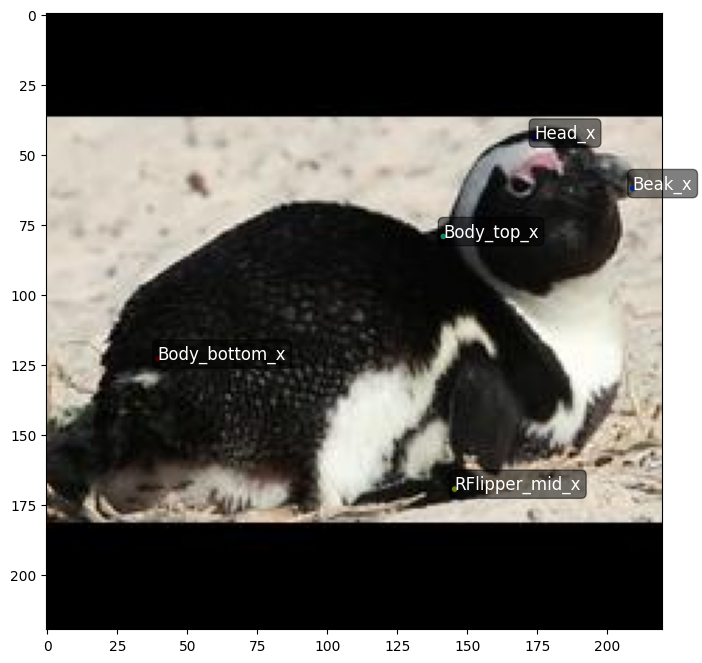

In [38]:
display_img = 259
chosen_img = train_imgs_array[display_img]
chosen_img_size = chosen_img.shape
print(chosen_img_size)
#print(original_img_shape)
chosen_img_keypoints = train_kp_array[display_img]
nkeypoints = 8
keypoint_labels = kp_cols[::2]

display_keypoints = unnorm_keypoints(chosen_img_size, chosen_img_keypoints)

plot_img_and_keypoint(chosen_img, display_keypoints, 8, keypoint_labels)

## 2.7. Building the model

### 2.7.1. Define the Loss function


In [32]:
def masked_mse(y_true, y_pred):
    """
    Computes the mean squared error, ignoring the invisible keypoints.
    Assuming that -10.0 indicates an invisible keypoint.
    """
    # Create a mask where keypoints are visible
    mask = (y_true != -10.0).float().to(y_true.device)

    # Apply the mask to filter out invisible keypoints from both
    # the predictions and the true values
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask

    # Compute the Mean Squared Error only on the visible keypoints
    mse = F.mse_loss(y_pred_masked, y_true_masked, reduction='sum') / mask.sum()
    return mse

In [39]:
# MANUAL IMPLEMENTATION OF THE ABOVE
# def masked_rmse_loss(y_true, y_pred):
#     """
#     Computes the Root Mean Square Error (RMSE) loss, ignoring the invisible keypoints (denoted by -10).
    
#     Parameters:
#     y_true (torch.Tensor): The ground truth keypoints (batch_size, num_keypoints*2).
#     y_pred (torch.Tensor): The predicted keypoints (batch_size, num_keypoints*2).

#     Returns:
#     torch.Tensor: The computed RMSE loss.
#     """
#     # Create a mask where keypoints are visible (not equal to -10)
#     mask = (y_true != -10.0).float()

#     # Apply the mask to filter out invisible keypoints
#     y_true_masked = y_true * mask
#     y_pred_masked = y_pred * mask

#     # Compute the squared differences
#     squared_diff = (y_pred_masked - y_true_masked) ** 2

#     # Compute the mean of squared differences for visible keypoints
#     loss = torch.sum(squared_diff) / torch.sum(mask)

#     # Return the square root of the loss to get RMSE
#     return torch.sqrt(loss)

# # Example usage:
# # Assume y_true and y_pred are your ground truth and predicted keypoints, respectively.
# # y_true = torch.tensor([...])
# # y_pred = torch.tensor([...])
# # loss = masked_rmse_loss(y_true, y_pred)

### 2.7.2. Define the evaluation metrics

In [33]:
# PCK
# put in a function that will use the max bbox if primary kp is missing
def pck_metric(y_true, y_pred, threshold=0.2):
    """
    Computes the Percentage of Correct Keypoints (PCK) metric.
    
    Parameters:
    y_true (torch.Tensor): The ground truth keypoints (batch_size, num_keypoints*2).
    y_pred (torch.Tensor): The predicted keypoints (batch_size, num_keypoints*2).
    threshold (float): The distance threshold for a keypoint to be considered correct.
                       Typically set relative to the size of the bounding box (e.g., 0.2).
    
    Returns:
    float: The percentage of correct keypoints.
    """
    # Create a mask where keypoints are visible (not equal to -10)
    mask = (y_true != -10.0).float().to(y_true.device)
    #print(mask)

    # Apply the mask to filter out invisible keypoints
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask

    # print(y_true_masked)
    # print(y_pred_masked)

    # Compute the Euclidean distance between the predicted and true keypoints
    distances = torch.sqrt((y_pred_masked[:, ::2] - y_true_masked[:, ::2]) ** 2 +
                           (y_pred_masked[:, 1::2] - y_true_masked[:, 1::2]) ** 2)
    
    #print(distances)
    
    # Normalize the distances (relative to the max and min y coord)
    Norm_max_min_kp = torch.max(y_true_masked[:, 1::2], dim=1)[0] - torch.min(y_true_masked[:, 1::2], dim=1)[0]
    # Normalise based on the distance between the head and the bottom of the body (position 0, 1 and )
    #print(y_true[:, 0],y_true[:,10],y_true[:, 1],y_true[:, 11])
    #print((y_true[:, 0] - y_true[:,10]) ** 2)
    #print((y_true[:, 1] - y_true[:, 11]) ** 2)
    Norm_head_lowerbody = torch.sqrt((y_true[:, 0] - y_true[:,10]) ** 2 +
                        (y_true[:, 1] - y_true[:, 11]) ** 2)
    #print(Norm_head_lowerbody)
    normalized_distances = distances / Norm_head_lowerbody[:, None]
    #print(distances)
    #print(normalized_distances)

    # Count the correct keypoints (distance <= threshold)
    correct_keypoints = (normalized_distances <= threshold).float() * mask[:, ::2]
    #print(correct_keypoints)

    # Calculate the PCK as the percentage of correct keypoints
    pck = correct_keypoints.sum() / mask[:, ::2].sum()
    return pck#.item()


In [34]:
# # create two tensors to check pck

# # Create two PyTorch tensors with the sizes (1, 16)
# # Initialize them with random values between -1 and 1
# tensor1_true = torch.rand(1, 16) * 2 - 1
# tensor2_pred = tensor1_true.clone()

# # creating a tensor with 2 predictions for an image (test that it will work for multiple inputs)
# # tensor2_pred = tensor1_true.clone()

# # Introduce some differences in tensor2
# tensor2_pred[0, :8] += torch.randn(8) * 0.1  # Slightly off for the first element of the first row

# tensor2_pred[0, :8] += torch.randn(8) * 0.1  # Slightly off for the first 8 elements of the first row
# #tensor2_pred[1, 8:] += torch.randn(8) * 0.1  # Slightly off for the last 8 elements of the second row

# # Ensure the values are still within the range [-1, 1]
# tensor2_pred = torch.clamp(tensor2_pred, min=-1, max=1)

# print(tensor1_true, tensor2_pred)

In [35]:
# print(tensor1_true, tensor2_pred)

In [36]:
# tensor1_true[0, 5] = -10
# tensor1_true[0, 4] = -10

In [37]:
# print(pck_metric(tensor1_true, tensor2_pred, 0.2))

### 2.7.3. Define the model

In [149]:
# First model (not correct sizes)
# class DeepPoseModel(nn.Module):
#     def __init__(self, nkeypoints=8):
#         # Initializes the DeepPoseModel with the dataset and training configuration.
#         super(DeepPoseModel, self).__init__()
        
#         # The feature extractor part of the model, composed of several convolutional layers.
#         self.features = nn.Sequential(
#             # Conv2d: Input channels = 3 (RGB image), Output channels = 96, kernel size = 11x11,
#             # stride = 4, padding = 4. 
#             # Input: (batch_size, 3, 220, 220)
#             # Output: (batch_size, 96, 55, 55)
#             nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=4),
            
#             # Local Response Normalization (LRN) over 5 neighboring channels
#             nn.LocalResponseNorm(5),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),

#             # Max pooling with 3x3 kernel and stride 2
#             # output size: (batch_size, 96, 27, 27)
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
#             # Conv2d: Input channels = 96, Output channels = 256, kernel size = 5x5,
#             # stride = 2, padding = 2.
#             # Input: (batch_size, 96, 27, 27)
#             # Output: (batch_size, 256, 27, 27)
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            
#             # Local Response Normalization (LRN) over 5 neighboring channels
#             nn.LocalResponseNorm(5),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),

#             # Max pooling with 3x3 kernel and stride 2
#             # output size: (batch_size, 96, 13, 13)
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
#             # Conv2d: Input channels = 256, Output channels = 384, kernel size = 3x3,
#             # stride = 1, padding = 1.
#             # Input: (batch_size, 256, 13, 13)
#             # Output: (batch_size, 384, 13, 13)
#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),
            
#             # Conv2d: Input channels = 384, Output channels = 384, kernel size = 3x3,
#             # stride = 1, padding = 1.
#             # Input: (batch_size, 384, 13, 13)
#             # Output: (batch_size, 384, 13, 13)
#             nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),
            
#             # Conv2d: Input channels = 384, Output channels = 256, kernel size = 3x3,
#             # stride = 1, padding = 1.
#             # Input: (batch_size, 384, 13, 13)
#             # Output: (batch_size, 256, 13, 13)
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),
            
#             # MaxPool2d: Kernel size = 3x3, stride = 2.
#             # Input: (batch_size, 256, 13, 13)
#             # Output: (batch_size, 256, 6, 6)
#             # Max pooling with 3x3 kernel and stride 2
#             nn.MaxPool2d(kernel_size=3, stride=2)
#         )
        
#         # The classifier part of the model, composed of fully connected layers.
#         self.classifier = nn.Sequential(
#             # Flatten the input tensor
#             # Input: (batch_size, 256, 6, 6)
#             # Output: (batch_size, 256 * 6 * 6) = (batch_size, 9216)
#             nn.Flatten(),
            
#             # Linear layer with input size 6400 and output size 4096
#             # Input: (batch_size, 6400)
#             # Output: (batch_size, 4096)
#             nn.Linear(256 * 6 * 6, 4096),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),
            
#             # Dropout layer with 60% dropout rate
#             nn.Dropout(0.6),
            
#             # Linear layer with input size 4096 and output size 4096
#             # Input: (batch_size, 4096)
#             # Output: (batch_size, 4096)
#             nn.Linear(4096, 4096),
            
#             # ReLU activation function applied in place (no extra memory allocation)
#             nn.ReLU(inplace=True),
            
#             # Dropout layer with 60% dropout rate
#             nn.Dropout(0.6),
            
#             # Final linear layer with input size 4096 and output size nkeypoints * 2
#             # Output is (nkeypoints * 2) coordinates (x, y) for each keypoint
#             # Input: (batch_size, 4096)
#             # Output: (batch_size, nkeypoints * 2)
#             nn.Linear(4096, nkeypoints * 2)
#         )
        
#     def forward(self, x):
#         # Define the forward pass through the network.
#         # Pass input `x` through the feature extractor
#         x = self.features(x)
#         # Pass the result through the classifier to get the final output
#         x = self.classifier(x)
#         return x

In [34]:
class DeepPoseModel(nn.Module):
    def __init__(self, nkeypoints=8):
        # Initializes the DeepPoseModel with the dataset and training configuration.
        super(DeepPoseModel, self).__init__()
        
        # The feature extractor part of the model, composed of several convolutional layers.
        self.features = nn.Sequential(
            # Conv2d: Input channels = 3 (RGB image), Output channels = 96, kernel size = 11x11,
            # stride = 4, padding = 4. 
            # Input: (batch_size, 3, 220, 220)
            # Output: (batch_size, 96, 55, 55)
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=4),
            
            # Local Response Normalization (LRN) over 5 neighboring channels
            nn.LocalResponseNorm(5),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),

            # Max pooling with 3x3 kernel and stride 2
            # output size: (batch_size, 96, 27, 27)
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv2d: Input channels = 96, Output channels = 256, kernel size = 5x5,
            # stride = 2, padding = 2.
            # Input: (batch_size, 96, 27, 27)
            # Output: (batch_size, 256, 27, 27)
            nn.Conv2d(48, 128, kernel_size=5, stride=1, padding=2),
            
            # Local Response Normalization (LRN) over 5 neighboring channels
            nn.LocalResponseNorm(5),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),

            # Max pooling with 3x3 kernel and stride 2
            # output size: (batch_size, 96, 13, 13)
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv2d: Input channels = 256, Output channels = 384, kernel size = 3x3,
            # stride = 1, padding = 1.
            # Input: (batch_size, 256, 13, 13)
            # Output: (batch_size, 384, 13, 13)
            nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # Conv2d: Input channels = 384, Output channels = 384, kernel size = 3x3,
            # stride = 1, padding = 1.
            # Input: (batch_size, 384, 13, 13)
            # Output: (batch_size, 384, 13, 13)
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # Conv2d: Input channels = 384, Output channels = 256, kernel size = 3x3,
            # stride = 1, padding = 1.
            # Input: (batch_size, 384, 13, 13)
            # Output: (batch_size, 256, 13, 13)
            nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # MaxPool2d: Kernel size = 3x3, stride = 2.
            # Input: (batch_size, 256, 13, 13)
            # Output: (batch_size, 256, 6, 6)
            # Max pooling with 3x3 kernel and stride 2
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # The classifier part of the model, composed of fully connected layers.
        self.classifier = nn.Sequential(
            # Flatten the input tensor
            # Input: (batch_size, 256, 6, 6)
            # Output: (batch_size, 256 * 6 * 6) = (batch_size, 9216)
            nn.Flatten(),
            
            # Linear layer with input size 6400 and output size 4096
            # Input: (batch_size, 6400)
            # Output: (batch_size, 4096)
            nn.Linear(128 * 6 * 6, 4096),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # Dropout layer with 60% dropout rate
            nn.Dropout(0.6),
            
            # Linear layer with input size 4096 and output size 4096
            # Input: (batch_size, 4096)
            # Output: (batch_size, 4096)
            nn.Linear(4096, 4096),
            
            # ReLU activation function applied in place (no extra memory allocation)
            nn.ReLU(inplace=True),
            
            # Dropout layer with 60% dropout rate
            nn.Dropout(0.6),
            
            # Final linear layer with input size 4096 and output size nkeypoints * 2
            # Output is (nkeypoints * 2) coordinates (x, y) for each keypoint
            # Input: (batch_size, 4096)
            # Output: (batch_size, nkeypoints * 2)
            nn.Linear(4096, nkeypoints * 2)
        )
        
    def forward(self, x):
        # Define the forward pass through the network.
        # Pass input `x` through the feature extractor
        x = self.features(x)
        # Pass the result through the classifier to get the final output
        x = self.classifier(x)
        return x

In [40]:
# DeepPose Model Summary
# model = DeepPoseModel()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)  # Move model to GPU
# summary(model, input_size=(3, 220, 220), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 55, 55]          17,472
 LocalResponseNorm-2           [-1, 48, 55, 55]               0
              ReLU-3           [-1, 48, 55, 55]               0
         MaxPool2d-4           [-1, 48, 27, 27]               0
            Conv2d-5          [-1, 128, 27, 27]         153,728
 LocalResponseNorm-6          [-1, 128, 27, 27]               0
              ReLU-7          [-1, 128, 27, 27]               0
         MaxPool2d-8          [-1, 128, 13, 13]               0
            Conv2d-9          [-1, 192, 13, 13]         221,376
             ReLU-10          [-1, 192, 13, 13]               0
           Conv2d-11          [-1, 192, 13, 13]         331,968
             ReLU-12          [-1, 192, 13, 13]               0
           Conv2d-13          [-1, 128, 13, 13]         221,312
             ReLU-14          [-1, 128,

In [117]:
# Original ALexNet model
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(AlexNet, self).__init__()
        
#         # Define the feature extractor part of the network
#         self.features = nn.Sequential(
#             # 1st Convolutional Layer: 3 input channels (RGB), 64 output channels, 11x11 kernel size, stride 4, padding 2
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             # Max pooling with 3x3 kernel and stride 2
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
#             # 2nd Convolutional Layer: 64 input channels, 192 output channels, 5x5 kernel size, stride 1, padding 2
#             nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(inplace=True),
#             # Max pooling with 3x3 kernel and stride 2
#             nn.MaxPool2d(kernel_size=3, stride=2),
            
#             # 3rd Convolutional Layer: 192 input channels, 384 output channels, 3x3 kernel size, stride 1, padding 1
#             nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
            
#             # 4th Convolutional Layer: 384 input channels, 256 output channels, 3x3 kernel size, stride 1, padding 1
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
            
#             # 5th Convolutional Layer: 256 input channels, 256 output channels, 3x3 kernel size, stride 1, padding 1
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             # Max pooling with 3x3 kernel and stride 2
#             nn.MaxPool2d(kernel_size=3, stride=2)
#         )
        
#         # Define the classifier part of the network
#         self.classifier = nn.Sequential(
#             # Flatten the input
#             nn.Flatten(),
#             # 1st Fully Connected Layer: input size 256 * 6 * 6, output size 4096
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
            
#             # 2nd Fully Connected Layer: input size 4096, output size 4096
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
            
#             # 3rd Fully Connected Layer (output layer): input size 4096, output size num_classes
#             nn.Linear(4096, num_classes)
#         )
        
#     def forward(self, x):
#         # Pass the input through the feature extractor
#         x = self.features(x)
#         # Pass the result through the classifier to get the final output
#         x = self.classifier(x)
#         return x


In [118]:
# AlexNet Summary
# model = AlexNet(num_classes=1000)  # Example model

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)  # Move model to GPU
# summary(model, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Flatten-14                 [-

## 2.8. Training model

In [35]:
def load_data_PyTorch(img_arr, kp_arr, batch_size, train_flag=True):
    '''
    Load data into PT dataset and dataLoader in specified batch size
    
    Params
    img_arr: images loaded into an array (i,255,255,3) and are converted to (i,3,255,255)
    kp_arr: array of keypoints (i, num_kp*2)
    batch_size: batch size 

    Return:
    PT_Dataset: containing input (x) and groundtruth (y)
    PT_DataLoader: Dataloader containing dataset and batch size

    '''

    # create tensors from arrays and load them to the GPU
    img_tensor = torch.tensor(img_arr, dtype=torch.float32).permute(0, 3, 1, 2).to('cuda')
    kp_tensor = torch.tensor(kp_arr, dtype=torch.float32).to('cuda')

    # Create a TensorDataset and DataLoader for training data
    dataset = TensorDataset(img_tensor, kp_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=train_flag)

    return dataset, dataloader

In [36]:
def create_timestamped_dir(base_dir='/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/DeepPose'):
    """
    Creates a directory with a timestamp appended to the base directory name.
    Returns the path to the created directory.
    
    Parameters:
    base_dir (str): The base directory name. Default is './training_results'.
    
    Returns:
    str: The path to the created directory.
    """
    # Get the current datetime and format it as YYYY-MM-DD_HH-MM-SS
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    
    # Create the final directory name with the timestamp
    final_dir = f"{base_dir}_{timestamp}"
    
    # Create the directory
    os.makedirs(final_dir, exist_ok=True)
    
    return final_dir


In [37]:
def plot_training_curves(train_data, val_data, save_dir, data_descriptor='Loss', show_plot=False):
    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_data, label=f'Training {data_descriptor}')
    plt.plot(val_data, label=f'Validation {data_descriptor}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{data_descriptor}')
    plt.title(f'Training and Validation {data_descriptor} Over Epochs')
    plt.legend()

    # Save the plot
    plot_path = os.path.join(save_dir, f'{data_descriptor}_plot.png')
    plt.savefig(plot_path)
    print(f'{data_descriptor} plot saved to {plot_path}')

    # Optionally, display the plot
    if show_plot == True:
        plt.show()

In [38]:
def save_stats_and_models(model, epoch, val_loss, val_pck, save_dir, 
                     best_val_loss=None, best_val_pck=None, 
                     final_model=False, train_loss_list=None, val_loss_list=None, train_pck_list=None, val_pck_list=None):
    """
    Saves the best models based on validation loss, PCK value, and final model.
    Saves the train and val curves and results for training
    
    Parameters:
    - model (torch.nn.Module): The PyTorch model to be saved.
    - epoch (int): The current epoch number.
    - val_loss (float): The current validation loss.
    - val_pck (float): The current validation PCK value.
    - save_dir (str): The directory where the models will be saved.
    - best_val_loss (float): The best validation loss seen so far.
    - best_val_pck (float): The best validation PCK value seen so far.
    - final_model (bool): If True, saves the final model after all epochs.
    - train_loss_list (list): List of all the loss values from each epoch
    
    Returns:
    - best_val_loss (float): Updated best validation loss.
    - best_val_pck (float): Updated best validation PCK value.
    """
    
    # Check if the current model has the lowest validation loss
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        model_name = f'best_val_loss_model_epoch_{epoch}_PCK_{val_pck:.4f}_loss_{val_loss:.4f}.pth'
        model_save_path = os.path.join(save_dir, model_name)
        torch.save(model.state_dict(), model_save_path)
        print(f'New best model saved with lowest validation loss to {model_save_path}')
    
    # Check if the current model has the highest validation PCK
    if best_val_pck is None or val_pck > best_val_pck:
        best_val_pck = val_pck
        model_save_path = os.path.join(save_dir, f'best_val_pck_model_epoch_{epoch}_PCK_{val_pck:.4f}_loss_{val_loss:.4f}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'New best model saved with highest validation PCK to {model_save_path}')
    
    # Save the final model and perform final stats evaluation and save
    if final_model:
        final_model_path = os.path.join(save_dir, f'final_model_epoch_{epoch}_PCK_{val_pck:.4f}_loss_{val_loss:.4f}.pth')
        torch.save(model.state_dict(), final_model_path)
        print(f'Final model saved to {final_model_path}')
        plot_training_curves(train_loss_list, val_loss_list, save_dir, 'Loss', show_plot=True)
        plot_training_curves(train_pck_list, val_pck_list, save_dir, data_descriptor='PCK@0.1', show_plot=True)
    
    return best_val_loss, best_val_pck

New best model saved with lowest validation loss to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/DeepPose_2024-08-20_16-03-02/best_val_loss_model_epoch_1_PCK_0.1823_loss_0.0244.pth
New best model saved with highest validation PCK to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/DeepPose_2024-08-20_16-03-02/best_val_pck_model_epoch_1_PCK_0.1823_loss_0.0244.pth
Epoch [1/30], Train Loss: 0.0397, Val Loss: 0.0244, Train PCK0.1: 0.1132, Val PCK0.1: 0.1823
New best model saved with lowest validation loss to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/DeepPose_2024-08-20_16-03-02/best_val_loss_model_epoch_2_PCK_0.2080_loss_0.0231.pth
New best model saved with highest validation PCK to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/DeepPose_2024-08-20_16-03-02/best_val_pck_model_epoch_2_PCK_0.2080_loss_0.0231.pth
Epoch [2/30], Train Loss: 0.0260, Val Loss: 0.0231, Train PCK0.1: 0.1654,

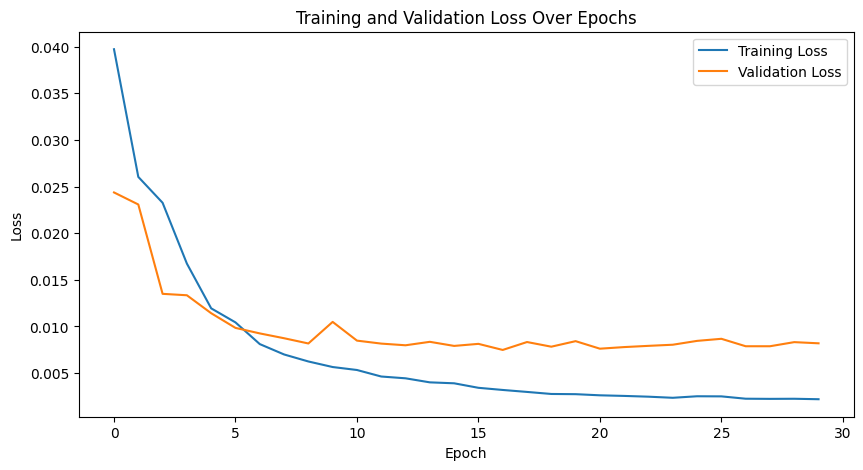

PCK@0.1 plot saved to /home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/DeepPose_2024-08-20_16-03-02/PCK@0.1_plot.png


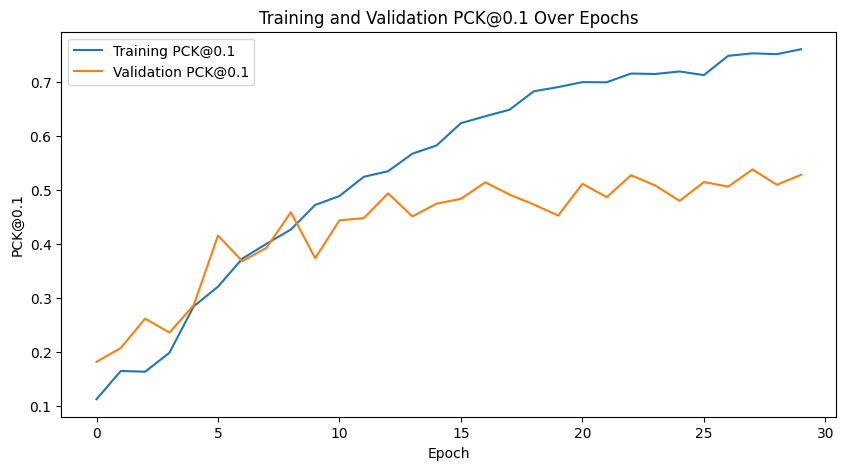

(0.007480905012926087, 0.537913803011179)

In [40]:
# this is where the training loop will go 

# Create the directory to save the results to
save_dir = create_timestamped_dir()

# Assuming the model, loss function, and optimizer are already defined
model = DeepPoseModel(nkeypoints=8).to('cuda')  # Move the model to GPU

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Load data into PT dataset and dataloader
train_dataset, train_dataloader = load_data_PyTorch(train_imgs_array, train_kp_array, 8)
val_dataset, val_dataloader = load_data_PyTorch(val_imgs_array, val_kp_array, 8, train_flag=False)

# Training loop (variables)
num_epochs = 30  # Adjust the number of epochs as needed

# Lists to store the training and validation loss for each epoch
train_losses = []
val_losses = []

train_pck_list = []
val_pck_list = []

best_val_loss = None
best_val_pck = None

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    running_pck_005 = 0.0
    running_pck_01 = 0.0
    running_pck_02 = 0.0
    running_pck_val_005 = 0.0
    running_pck_val_01 = 0.0
    running_pck_val_02 = 0.0
    
    for batch_images, batch_keypoints in train_dataloader:
        # Move the data to the GPU
        batch_images = batch_images.to('cuda')
        batch_keypoints = batch_keypoints.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(batch_images)
        # Compute the loss
        loss = masked_mse(batch_keypoints, outputs)
        #print(loss)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Accumulate the loss
        running_train_loss += loss.item()
        #print(running_train_loss)

        # compute metrics
        #pck_005 = pck_metric(batch_keypoints, outputs, 0.05)
        pck_01 = pck_metric(batch_keypoints, outputs, 0.1)
        #pck_02 = pck_metric(batch_keypoints, outputs, 0.2)

        #running_pck_005 += pck_005.item()
        running_pck_01 += pck_01.item()
        #running_pck_02 += pck_02.item()

            
    avg_train_loss = running_train_loss / len(train_dataloader)
    #avg_pck_005 = running_pck_005 / len(train_dataloader)
    avg_pck_01 = running_pck_01 / len(train_dataloader)
    #avg_pck_02 = running_pck_02 / len(train_dataloader)

    # populate train losses list for evaluation
    train_losses.append(avg_train_loss)

    train_pck_list.append(avg_pck_01)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for batch_images, batch_keypoints in val_dataloader:
            # Move the data to the GPU
            batch_images = batch_images.to('cuda')
            batch_keypoints = batch_keypoints.to('cuda')

            outputs = model(batch_images)
            loss = masked_mse(batch_keypoints, outputs)
            running_val_loss += loss.item()

            # compute metrics
            #pck_005 = pck_metric(batch_keypoints, outputs, 0.05)
            pck_01_val = pck_metric(batch_keypoints, outputs, 0.1)
            #pck_02 = pck_metric(batch_keypoints, outputs, 0.2)
            #running_pck_val_005 = pck_metric(batch_keypoints, outputs, 0.05)
            running_pck_val_01 += pck_01_val.item()
            #running_pck_val_02 = pck_metric(batch_keypoints, outputs, 0.2)

    
    avg_val_loss = running_val_loss / len(val_dataloader)
    #avg_pck_005 = running_pck_005 / len(train_dataloader)
    avg_val_pck_01 = running_pck_val_01 / len(val_dataloader)
    #avg_pck_02 = running_pck_02 / len(train_dataloader)

    # populate val losses list for evaluation
    val_losses.append(avg_val_loss)

    val_pck_list.append(avg_val_pck_01)

    # save best performing models based on the PCK and loss as well as the stats
    best_val_loss, best_val_pck = save_stats_and_models(
    model, epoch + 1, avg_val_loss, avg_val_pck_01, save_dir, 
    best_val_loss, best_val_pck)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train PCK0.1: {avg_pck_01:.4f}, Val PCK0.1: {avg_val_pck_01:.4f}')
    
save_stats_and_models(model, num_epochs, avg_val_loss, avg_val_pck_01, save_dir, 
                 best_val_loss, best_val_pck, final_model=True, train_loss_list=train_losses, 
                 val_loss_list=val_losses, train_pck_list=train_pck_list, val_pck_list=val_pck_list)

## 2.9. Evaluating the model 

In [44]:
def load_model(model_path, model_class, device='cuda'):
    """
    Loads a PyTorch model from a .pth file.

    Parameters:
    - model_path (str): The path to the .pth model file.
    - model_class (torch.nn.Module): The class of the model to instantiate.
    - device (str): The device to load the model onto ('cuda' or 'cpu').

    Returns:
    - model (torch.nn.Module): The loaded PyTorch model.
    """
    # Instantiate the model class
    model = model_class().to(device)
    
    # Load the state dictionary into the model
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

In [43]:

def predict(model, images, img_is_tensor=False, device='cuda'):
    """
    Generates predictions from a PyTorch model given an array of images.

    Parameters:
    - model (torch.nn.Module): The PyTorch model to use for predictions.
    - images (np.array): Array of images (e.g., shape: (num_images, 220, 220, 3)).
    - device (str): The device to run the model on ('cuda' or 'cpu').

    Returns:
    - predictions (np.array): Array of predictions (e.g., keypoints for each image).
    """
    # Convert images to PyTorch tensor and move to the specified device
    if not img_is_tensor:
        images_tensor = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    
    # Forward pass through the model to get predictions
    with torch.no_grad():
        predictions = model(images_tensor)
    
    # Convert predictions back to a NumPy array and move to CPU if necessary
    predictions = predictions.cpu().numpy() if device == 'cuda' else predictions.numpy()
    
    return predictions

In [ ]:
def plot_comparison(img, pred_keypoints, true_keypoints, nkeypoints, keypoint_labels=None):
    """
    Plots predicted keypoints vs. ground truth keypoints on the same image.

    Parameters:
    - img: The image on which to plot the keypoints.
    - pred_keypoints: The predicted keypoints (flattened x, y coordinates).
    - true_keypoints: The ground truth keypoints (flattened x, y coordinates).
    - nkeypoints: The number of keypoints.
    - keypoint_labels: Optional list of keypoint labels to display next to the keypoints.
    """

    fig = plt.figure(figsize=(8, 8), dpi=100)
    plt.imshow(img)
    
    # Extract x and y coordinates for predicted keypoints
    pred_x_keypoints = pred_keypoints[::2]
    pred_y_keypoints = pred_keypoints[1::2]
    
    # Extract x and y coordinates for ground truth keypoints
    true_x_keypoints = true_keypoints[::2]
    true_y_keypoints = true_keypoints[1::2]
    
    # Plot predicted keypoints
    plt.scatter(pred_x_keypoints, pred_y_keypoints, marker='o', c='g', label='Predicted', edgecolor='black')
    
    # Plot ground truth keypoints
    plt.scatter(true_x_keypoints, true_y_keypoints, marker='x', c='r', label='Ground Truth')
    
    # If labels are provided, add them to the plot
    if keypoint_labels is not None:
        for i, (x, y) in enumerate(zip(true_x_keypoints, true_y_keypoints)):
            plt.text(x, y, keypoint_labels[i], fontsize=12, color='white',
                     bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

    # Add a legend to differentiate between predicted and ground truth keypoints
    plt.legend()

    # Save the plot
    plot_path = os.path.join(save_dir, f'{data_descriptor}_plot.png')
    plt.savefig(plot_path)
    print(f'{data_descriptor} plot saved to {plot_path}')


    plt.show()


In [45]:
# Example usage:
# Assuming `MyModelClass` is the class of your model
# and `images_array` is your array of images with shape (num_images, 3, 220, 220)

model_path = '/home/matthew/Desktop/Master_Dev/masters_penguin_pose_estimation/runs/PE/DeepPose_2024-08-20_16-03-02/best_val_pck_model_epoch_17_PCK_0.5142_loss_0.0075.pth'
images_array = val_imgs_array[3:8,:,:,:]  # Replace with your actual images

# Load the model
model = load_model(model_path, DeepPoseModel, device='cuda')

# Get predictions
predictions = predict(model, images_array, device='cuda')

plot_comparison

print(predictions)

[[-0.14409065 -0.45013702 -0.27775988 -0.38483348 -0.05732398 -0.22737204
  -0.08037797  0.01273427 -0.05398332  0.143733    0.20863113  0.2500993
   0.04194462  0.36497366  0.0434872   0.41587973]
 [-0.14988571 -0.44863033 -0.28051323 -0.3799352  -0.06141984 -0.22874017
  -0.08404186  0.01243726 -0.0473132   0.13840368  0.20111282  0.2502317
   0.03876939  0.3658955   0.04660829  0.41589323]
 [-0.13272041 -0.41486344 -0.23537083 -0.34783366 -0.09040489 -0.19229697
  -0.12271658  0.03089211  0.01384075  0.11506388  0.13283367  0.23905244
   0.00728462  0.34860516  0.06076482  0.3890457 ]
 [-0.17811841 -0.41736177 -0.32624558 -0.33903775 -0.06822034 -0.22217835
  -0.09445179  0.01103433 -0.02524448  0.13103916  0.21137598  0.2191611
   0.03520606  0.35075197  0.05660679  0.40209213]
 [-0.1681532  -0.3895079  -0.29462492 -0.31208998 -0.08378034 -0.20447111
  -0.10368232  0.0247257   0.01992463  0.10418839  0.1503256   0.2077736
   0.01936213  0.33836475  0.06885201  0.3795801 ]]


In [42]:
# compare some poses
val_imgs_array.shape

(60, 220, 220, 3)